In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
import uuid
import sys
sys.path.append('../lib')
import shane
import mint_v2
import token_logic_modules as tlm


# Random Scenarios Testing

This notebook tests the models against a series of random scenarios. In these scenarios the following parameters are picked at random:
- **POKT value** : The value of a single POKT token in USD.
- **Total Relays** : The total number of relays in the network.
- **Number of Services** : The total number of services in the network.
- **Compute Units per Service** : The cost of the relays, in CU, for each of the services in the network.
- **Nodes per Service** : The amount of nodes in each of the services.
- **Relays per Service** : The amount of relays in each of the services.

# Parameters

In [2]:
# Set the sweep limits for each parameter
num_sweeps = 10 # Number of samples to get from the sweeped variables
USE_GEOM = True # Wether to use geometric spaces or linear spaces in the sweeps

### Price ###
min_price_sweep = 0.01
max_price_sweep = 5.0

### Relays ###
min_relays_sweep = 0.2e9
max_relays_sweep = 40e9

### Services ###
min_services_sweep = 50
max_services_sweep = 500

# These parameters are drawn randomly, they are not sweeps, so we need to sample
# them with different methods
num_draws = 10  # Number of samples to get from the drawn variables
# Not for each of them, but from them all together

### CUs per Service ###
# For each service, we flip a coin:
#   -> if heads, the service cost is changed randomly
#   -> if tails, the service cost remains the same
# The probability of the coin should remain low enough, otherwise we can see a drift
# in the average cost of the relays that will reflect as having more traffic overall.
# (also the base fee of the network is based on a 100 CUs per relay to be Morse comparable)
change_prob_service_cost = 0.1
mean_service_cost = 100 # This is the cost of an unchanged service
changed_mean_service_cost = 500 # If the service cost is selected to be changed, this will be the mean of the distribution
changed_std_service_cost = 50 # and this the standard deviation of the new service cost draw

### Number of nodes per service ###
# This is also a random uniform
min_num_nodes = 50
max_num_nodes = 50e3

### Number of relays per service ###
# This is how the relays are distributed, the total number does not matter
# as it will be overriden by the sweept parameter, the important part here
# is the shape, that has been historically a something like a Beta distribution
relays_alpha_param = 2
relays_beta_param = 5

### Fixed Network Parameters

In [3]:
# Network Conditions that won't be changing
network_macro = dict()
network_macro['total_supply'] = 1679901301.43    # POKT
network_macro['POKT_stake_per_node'] = 60e3      # POKT (irrelevant but for APR calculation, which is a non-goal)
network_macro['cu_cost'] = 0.0000000085 # USD/CU
network_macro["mint_share"] = {
    "DAO": 0.10,
    "Validator": 0.05,
    "Supplier": 0.7,
    "Source": 0.15,
}

assert sum(network_macro['mint_share'].values()) == 1, "The mint share must sum 1 (100%%)"

In [4]:
# Set up tokenomics models to test
models_test = dict()

### Shane's Parameters

In [5]:
shane_params = dict()

# Supplier Boost
shane_params['deflation_threshold'] = 25e9      # relays by day

shane_params['max_mint_per_day'] = 180e3       # POKT
# Sources Boost
shane_params['cutoff_point'] = 20e9             # relays/day
shane_params['prop_of_CUF'] = 0.7               # -

# Miscellaneous (Sources Boost)
shane_params['prop_ceiling'] = 0.0              # -
shane_params['floor_relays'] = 5e9              # relays by day
shane_params['gfpr_rar_ceiling_relays'] = 1.5e9 # relays by day
shane_params['gfpr_rar_prop_ceiling'] = 0.15    # -
shane_params['gfpr_rar_floor_relays'] = 5e6     # relays by day
shane_params['gfpr_rar_prop_floor'] = 0.9       # -
shane_params['gfpr_rar_max_supplier_boost'] = 40e3 # USD


In [6]:
models_test['Shane'] = dict()
models_test['Shane']['params'] = shane_params
models_test['Shane']['process_fcn'] = shane.process

### MINT-V2 Parameters

In [7]:
mint_v2_params = deepcopy(mint_v2.data_dict_defaults)

# Ecosystem Costs and Charges
mint_v2_params["MaturityComputeUnitsCharge"]                = 0.85e-8       # USD/ComputeUnits
mint_v2_params["MaturityComputeUnitsCost"]                  = 0.85e-8       # USD/ComputeUnits
mint_v2_params["SupplyGrowCap"]                             = 0.05          # times
# Gateways
mint_v2_params["MinBootstrapGatewayFeePerComputeUnits"]     = 0.85e-8       # USD/ComputeUnits
mint_v2_params["GatewaysBootstrapUnwindStart"]              = 250           # Billon ComputeUnits/day
mint_v2_params["GatewaysBootstrapEnd"]                      = 2500          # Billon ComputeUnitss/day
# Servicers
mint_v2_params["MaxBootstrapServicerCostPerComputeUnits"]   = 5e-8          # USD/ComputeUnits
mint_v2_params["ServicersBootstrapUnwindStart"]             = 250           # Billon ComputeUnits/day
mint_v2_params["ServicersBootstrapEnd"]                     = 2500          # Billon ComputeUnits/day
mint_v2_params["MinUsdMint"]                                = 20e3          # USD/day

# Check that the minimum minting is not higher than the maturity (miny <= burn) phase miniting
assert mint_v2_params["MinUsdMint"] <= mint_v2_params["MaturityComputeUnitsCharge"]*mint_v2_params["GatewaysBootstrapEnd"]*1e9
assert mint_v2_params["GatewaysBootstrapEnd"] >= mint_v2_params["ServicersBootstrapEnd"]

# Additional parameters to activate entropy (just for test)
mint_v2_params['apply_entropy'] = False

In [8]:
models_test['MINT-V2'] = dict()
models_test['MINT-V2']['params'] = mint_v2_params
models_test['MINT-V2']['process_fcn'] = mint_v2.process

### Token Logic Modules (TLMs) Parameters

This is only a simple override, please see all parameters in the module file.

In [9]:
tlm_params = deepcopy(tlm.global_params_dict)
tlm_params['core_TLM']['cu_cost'] = network_macro['cu_cost']
tlm_params['apply_entropy'] = mint_v2_params['apply_entropy']

In [10]:
models_test['TLM'] = dict()
models_test['TLM']['params'] = tlm_params
models_test['TLM']['process_fcn'] = tlm.process

# Process

### Run Models

For each random scenario, check each of the models described before

In [11]:
# Create parameters grid
if USE_GEOM:
    # Geometric Space
    relays_sweep = np.geomspace(min_relays_sweep, max_relays_sweep, num_sweeps)
    price_sweep = np.geomspace(min_price_sweep, max_price_sweep, num_sweeps)
    services_sweep = np.geomspace(min_services_sweep, max_services_sweep, num_sweeps)
else:
    # Linear Space
    relays_sweep = np.linspace(min_relays_sweep, max_relays_sweep, num_sweeps)
    price_sweep = np.linspace(min_price_sweep, max_price_sweep, num_sweeps)
    services_sweep = np.linspace(min_services_sweep, max_services_sweep, num_sweeps)


In [12]:
sweep_results = list()

# I know, I know...
for i_r, relays_now in enumerate(relays_sweep):
    print("%d/%d"%(i_r+1, num_sweeps))
    for i_p, price_now in enumerate(price_sweep):
        # print("\t%d/%d"%(i_p+1, num_sweeps))
        for i_s, services_now in enumerate(services_sweep):
            # print("\t\t%d/%d"%(i_s+1, num_sweeps))

            services_now = int(services_now)

            # Sample random scenarios here
            for i_d in range(num_draws):
                # Get a vector of random relays
                relays_vector = np.random.beta(a=relays_alpha_param, b=relays_beta_param, size=services_now)
                # Normalize to given amount
                relays_vector /= relays_vector.sum()
                relays_vector *= relays_now
                relays_vector = relays_vector.astype(int)
                # Get a vector of nodes in each service
                nodes_per_service = np.random.uniform(min_num_nodes, max_num_nodes, services_now).astype(int)
                # Default CUs per service
                CUs_per_service = np.ones_like(nodes_per_service)*mean_service_cost
                # Get how many services will have different cost
                services_to_change = np.random.binomial(services_now, change_prob_service_cost)
                # Choose the services to change
                to_change = np.random.choice(np.arange(services_now), services_to_change)
                # Change each of the selected services
                for service in to_change:
                    CUs_per_service[service] = int(np.random.normal(loc=changed_mean_service_cost, scale=changed_std_service_cost))

                # Random service names
                names = [str(uuid.uuid4())[-5:] for _ in range(services_now)]

                # Create the chains dataframe
                chains_df = pd.DataFrame(np.stack([names, relays_vector, CUs_per_service, nodes_per_service]).T, columns=['Chain', 'relays', 'cu_per_relay', 'active_nodes'])
                chains_df = chains_df.astype({'Chain': 'str', 'relays': 'int64', 'cu_per_relay': 'int64', 'active_nodes': 'int64'})

                # Fill network macro data
                network_macro['POKT_value'] = price_now
                network_macro['daily_relays'] = chains_df['relays'].sum()
                network_macro['supplier_nodes'] = chains_df['active_nodes'].sum()

                # Process each model
                for model_name in models_test.keys():
                    _, results = models_test[model_name]['process_fcn'](chains_df, network_macro, models_test[model_name]['params'])

                    # Add sample point data
                    row_values = list([model_name, relays_now, price_now, services_now])
                    # Supply growth rate
                    row_values.append(((results['total_mint'] - results['total_burn'])*365.25/network_macro['total_supply'])*100.)
                    # Over-minted total
                    row_values.append(results['total_mint']-results['total_burn'])
                    # POKT burnt
                    row_values.append(results['total_burn'])
                    # Supplier monthly income in USD
                    month_income_usd = results['total_mint_supplier']*30.4*network_macro['POKT_value'] /network_macro['supplier_nodes']
                    row_values.append(month_income_usd)
                    # Suplier APR
                    row_values.append(((month_income_usd/30.4)*365./(network_macro['POKT_stake_per_node']*network_macro['POKT_value']))*100.)
                    # Over-mint per day due to suppliers extra minting
                    row_values.append(results['total_mint_supplier']-results['total_burn'] * network_macro["mint_share"]["Supplier"])
                    # Over-minted to sources
                    row_values.append(results['total_mint_supplier']-results['total_burn'] * network_macro["mint_share"]["Supplier"])

                    # Per-Service stuff
                    node_avg_list = list()
                    imbalance_list = list()
                    for chain in results['services'].keys():
                        node_avg_list.append(results['services'][chain]['mint_per_node'])
                        imbalance_list.append(results['services'][chain]['service_imbalance'])
                    node_avg_list = np.array(node_avg_list)
                    imbalance_list = np.array(imbalance_list)
                    # Per service average POKT
                    row_values.append(np.mean(node_avg_list))
                    # Per service std POKT
                    row_values.append(np.std(node_avg_list))
                    # Per service max POKT
                    row_values.append(np.max(node_avg_list))
                    # Per service min POKT
                    row_values.append(np.min(node_avg_list))
                    # Per service average imbalance
                    row_values.append(np.mean(imbalance_list))
                    # Per service std imbalance
                    row_values.append(np.std(imbalance_list))
                    # Per service max imbalance
                    row_values.append(np.max(imbalance_list))
                    # Per service min imbalance
                    row_values.append(np.min(imbalance_list))

                    # Get minting per node of services under and over provisioned
                    # Overprovisioned
                    min_i = np.argmin(imbalance_list)
                    row_values.append(node_avg_list[min_i])
                    max_i = np.argmax(imbalance_list)
                    row_values.append(node_avg_list[max_i])

                    # Add result
                    sweep_results.append(row_values)

1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
10/10


In [13]:
sweep_results_df = pd.DataFrame(
    sweep_results,
    columns=[
        "Model",
        "relays",
        "Price",
        "Services",
        "Supply Growth Rate [%]",
        "Over-minting per Day [POKT]",
        "POKT burnt per Day [POKT]",
        "Supplier Income per Day [USD]",
        "Supplier APR (USD) [%]",
        "Over-mint per Day for Supplier [POKT]",
        "Over-mint per Day for Sources [POKT]",
        "Per Service Avg. Gain per Node and Day [POKT]",
        "Per Service Std. Gain per Node and Day [POKT]",
        "Per Service Max. Gain per Node and Day [POKT]",
        "Per Service Min. Gain per Node and Day [POKT]",
        "Per Service Avg. Imbalance [-]",
        "Per Service Std. Imbalance [-]",
        "Per Service Max. Imbalance [-]",
        "Per Service Min. Imbalance [-]",
        "Per Service Avg. Gain per Node and Day (Over-Provisioned) [POKT]",
        "Per Service Avg. Gain per Node and Day (Under-Provisioned) [POKT]",
    ],
)

In [14]:
sweep_results_df

,Model,relays,Price,Services,Supply Growth Rate [%],Over-minting per Day [POKT],POKT burnt per Day [POKT],Supplier Income per Day [USD],Supplier APR (USD) [%],Over-mint per Day for Supplier [POKT],...,Per Service Avg. Gain per Node and Day [POKT],Per Service Std. Gain per Node and Day [POKT],Per Service Max. Gain per Node and Day [POKT],Per Service Min. Gain per Node and Day [POKT],Per Service Avg. Imbalance [-],Per Service Std. Imbalance [-],Per Service Max. Imbalance [-],Per Service Min. Imbalance [-],Per Service Avg. Gain per Node and Day (Over-Provisioned) [POKT],Per Service Avg. Gain per Node and Day (Under-Provisioned) [POKT]
0,Shane,2.000000e+08,0.01,50,4.242958e+00,1.951472e+05,24070.076429,0.034312,0.068661,1.530000e+05,...,0.449503,1.330234,6.903109,0.005384,3.314722,9.809397,50.904818,0.039704,0.005384,6.903109
1,MINT-V2,2.000000e+08,0.01,50,5.000685e+00,2.299974e+05,24070.076429,0.035928,0.071894,1.609982e+05,...,0.559632,1.656143,8.594379,0.006703,3.314722,9.809397,50.904818,0.039704,0.006703,8.594379
2,TLM,2.000000e+08,0.01,50,5.541247e-01,2.548596e+04,24070.076429,0.007008,0.014023,1.784017e+04,...,0.109157,0.323032,1.676339,0.001307,3.314722,9.809397,50.904818,0.039704,0.001307,1.676339
3,Shane,2.000000e+08,0.01,50,4.188590e+00,1.926466e+05,20084.937908,0.040778,0.081600,1.530000e+05,...,0.617667,2.051466,14.509185,0.015745,3.844682,12.769403,90.312808,0.098005,0.015745,14.509185
4,MINT-V2,2.000000e+08,0.01,50,5.000685e+00,2.299974e+05,20084.937908,0.042730,0.085507,1.609982e+05,...,0.772010,2.564088,18.134756,0.019679,3.844682,12.769403,90.312808,0.098005,0.019679,18.134756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,MINT-V2,4.000000e+10,5.00,500,-1.186473e-16,-5.456968e-12,9109.065706,0.080265,0.000321,3.637979e-12,...,0.002719,0.013575,0.238697,0.000030,3.603841,17.994702,316.417093,0.039219,0.000030,0.238697
29996,TLM,4.000000e+10,5.00,500,1.980525e-01,9.109066e+03,9109.065706,0.160531,0.000642,6.376346e+03,...,0.005437,0.027149,0.477393,0.000059,3.603841,17.994702,316.417093,0.039219,0.000059,0.477393
29997,Shane,4.000000e+10,5.00,500,0.000000e+00,0.000000e+00,9537.487616,0.079784,0.000319,9.094947e-13,...,0.005855,0.065886,1.202836,0.000020,7.808773,87.866460,1604.107111,0.027059,0.000020,1.202836
29998,MINT-V2,4.000000e+10,5.00,500,-3.954910e-17,-1.818989e-12,9537.487616,0.079784,0.000319,-2.728484e-12,...,0.005855,0.065886,1.202836,0.000020,7.808773,87.866460,1604.107111,0.027059,0.000020,1.202836


### Aggregate results

Take the dataframe created from running the models in each scenario and arrange them into an structure containing the means and standard deviations of each of the metrics that we observed.


In [15]:
result_tensor_size = (len(relays_sweep),len(price_sweep), len(services_sweep))
agg_results = dict()
for model_name in models_test.keys():
    agg_results[model_name] = dict()
    agg_results[model_name]['Total Mint'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Total Burn'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Income DAO'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Income Validators'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Income Supplier'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Income Sources'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Node APR'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Income Node per Service'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Imbalance per Service'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Over-Provisioned Income Node per Service'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }
    agg_results[model_name]['Under-Provisioned Income Node per Service'] = {
        'mean' : np.zeros(result_tensor_size),
        'std' : np.zeros(result_tensor_size)
    }

chains_df_copy = deepcopy(chains_df)
for i_r, relays_now in enumerate(relays_sweep):
    for i_p, price_now in enumerate(price_sweep):
        for i_s, services_now in enumerate(services_sweep):
            services_now = int(services_now)
            for model_name in models_test.keys():

                # Get this slice
                slice_df = sweep_results_df.loc[(sweep_results_df['Model'] == model_name) *\
                                             (sweep_results_df['relays'] == relays_now) *\
                                                (sweep_results_df['Price'] == price_now) *\
                                                    (sweep_results_df['Services'] == services_now)]

                total_mint = (slice_df['Over-minting per Day [POKT]']+slice_df['POKT burnt per Day [POKT]'])
                agg_results[model_name]['Total Mint']['mean'][i_r, i_p, i_s] = total_mint.mean()
                agg_results[model_name]['Total Mint']['std'][i_r, i_p, i_s] = total_mint.std()

                agg_results[model_name]['Total Burn']['mean'][i_r, i_p, i_s] = slice_df['POKT burnt per Day [POKT]'].mean()
                agg_results[model_name]['Total Burn']['std'][i_r, i_p, i_s] = slice_df['POKT burnt per Day [POKT]'].std()

                total_shareable_mint = (
                    slice_df["Over-mint per Day for Supplier [POKT]"]
                    + slice_df["POKT burnt per Day [POKT]"]
                )
                total_shareable_mint_mean = total_shareable_mint.mean()
                total_shareable_mint_std = total_shareable_mint.std()

                agg_results[model_name]['Income DAO']['mean'][i_r, i_p, i_s] = total_shareable_mint_mean*network_macro['mint_share']['DAO']
                agg_results[model_name]['Income DAO']['std'][i_r, i_p, i_s] = total_shareable_mint_std*network_macro['mint_share']['DAO']

                agg_results[model_name]['Income Validators']['mean'][i_r, i_p, i_s] = total_shareable_mint_mean*network_macro['mint_share']['Validator']
                agg_results[model_name]['Income Validators']['std'][i_r, i_p, i_s] = total_shareable_mint_std*network_macro['mint_share']['Validator']

                agg_results[model_name]["Income Supplier"]["mean"][i_r, i_p, i_s] = (
                    total_shareable_mint_mean * network_macro["mint_share"]["Supplier"]
                )
                agg_results[model_name]["Income Supplier"]["std"][i_r, i_p, i_s] = (
                    total_shareable_mint_std * network_macro["mint_share"]["Supplier"]
                )

                agg_results[model_name]['Income Sources']['mean'][i_r, i_p, i_s] = (total_shareable_mint*network_macro['mint_share']['Source']+slice_df['Over-mint per Day for Sources [POKT]']).mean()
                agg_results[model_name]['Income Sources']['std'][i_r, i_p, i_s] = (total_shareable_mint*network_macro['mint_share']['Source']+slice_df['Over-mint per Day for Sources [POKT]']).std()

                agg_results[model_name]['Income Node per Service']['mean'][i_r, i_p, i_s] = slice_df['Per Service Avg. Gain per Node and Day [POKT]'].mean()
                agg_results[model_name]['Income Node per Service']['std'][i_r, i_p, i_s] = slice_df['Per Service Avg. Gain per Node and Day [POKT]'].std()

                agg_results[model_name]['Imbalance per Service']['mean'][i_r, i_p, i_s] = slice_df['Per Service Avg. Imbalance [-]'].mean()
                agg_results[model_name]['Imbalance per Service']['std'][i_r, i_p, i_s] = slice_df['Per Service Avg. Imbalance [-]'].std()

                agg_results[model_name]["Node APR"]["mean"][i_r, i_p, i_s] = slice_df[
                    "Supplier APR (USD) [%]"
                ].mean()
                agg_results[model_name]["Node APR"]["std"][i_r, i_p, i_s] = slice_df[
                    "Supplier APR (USD) [%]"
                ].std()

                agg_results[model_name]['Over-Provisioned Income Node per Service']['mean'][i_r, i_p, i_s] = slice_df['Per Service Avg. Gain per Node and Day (Over-Provisioned) [POKT]'].mean()
                agg_results[model_name]['Over-Provisioned Income Node per Service']['std'][i_r, i_p, i_s] = slice_df['Per Service Avg. Gain per Node and Day (Over-Provisioned) [POKT]'].std()

                agg_results[model_name]['Under-Provisioned Income Node per Service']['mean'][i_r, i_p, i_s] = slice_df['Per Service Avg. Gain per Node and Day (Under-Provisioned) [POKT]'].mean()
                agg_results[model_name]['Under-Provisioned Income Node per Service']['std'][i_r, i_p, i_s] = slice_df['Per Service Avg. Gain per Node and Day (Under-Provisioned) [POKT]'].std()

# Plots / Analysis

In [16]:
feat = 'mean'

# Seein 4 dimensions is dificult, so we will sample the least important dimension (number of services)
# and show separate graphics at each slice
num_services_show = [0, int(num_sweeps/2), -1]

color_map_supply_grow_limits = [-5, 5]              # [%]
color_map_income_limits = [1e3, 50e3]               # [USD]
node_apy_colorbar_limits=[0.01, 0.2]                # [%]
node_mean_income_colorbar_limits=[0.01, 0.5]        # [POKT]
over_provision_colorbar_limits=[0.001, 0.05]        # [-] (its a ratio, "times")
under_provision_colorbar_limits=[0.1, 50]           # [-] (its a ratio, "times")

# Just because we will re-use this many times...
models_list = list(agg_results.keys())


### Supply Growth

The percentage of the total supply that is minted per year, also known as (mistakenly) as "inflation".


/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_86002/1182739012.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


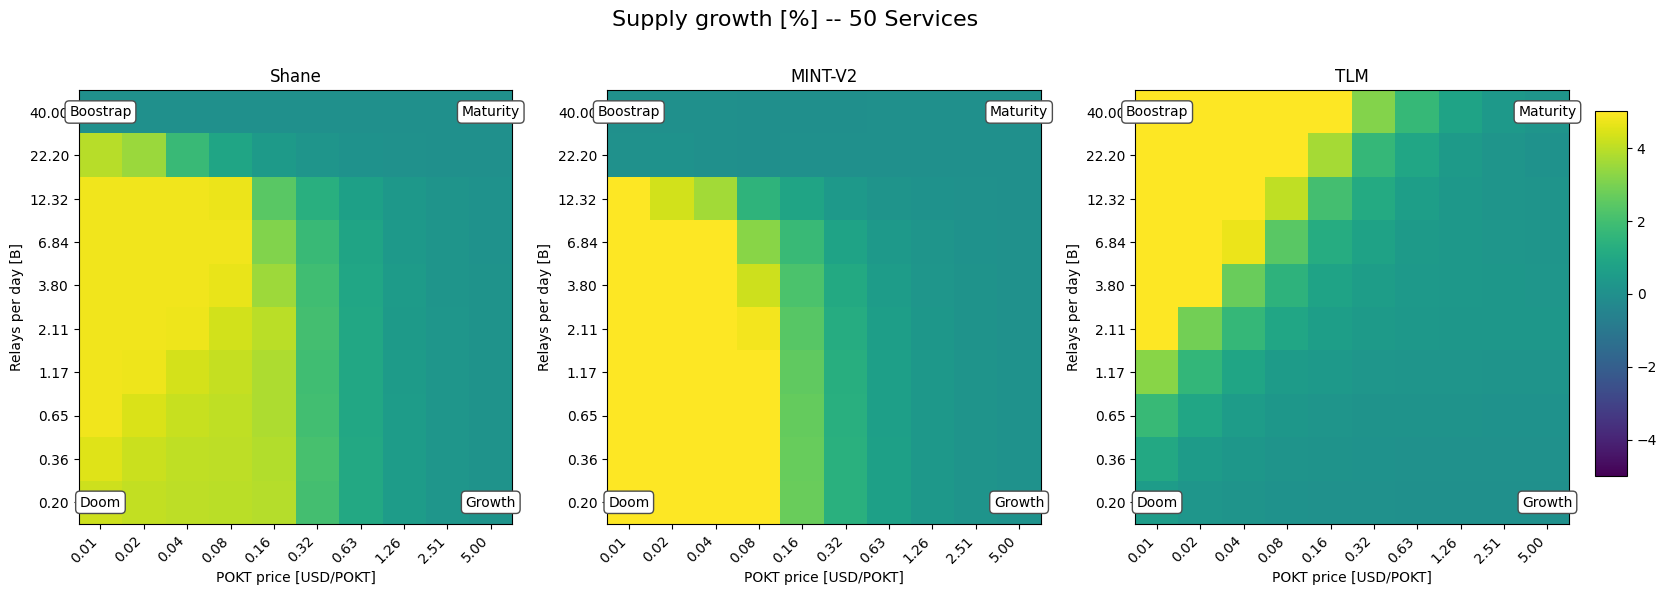

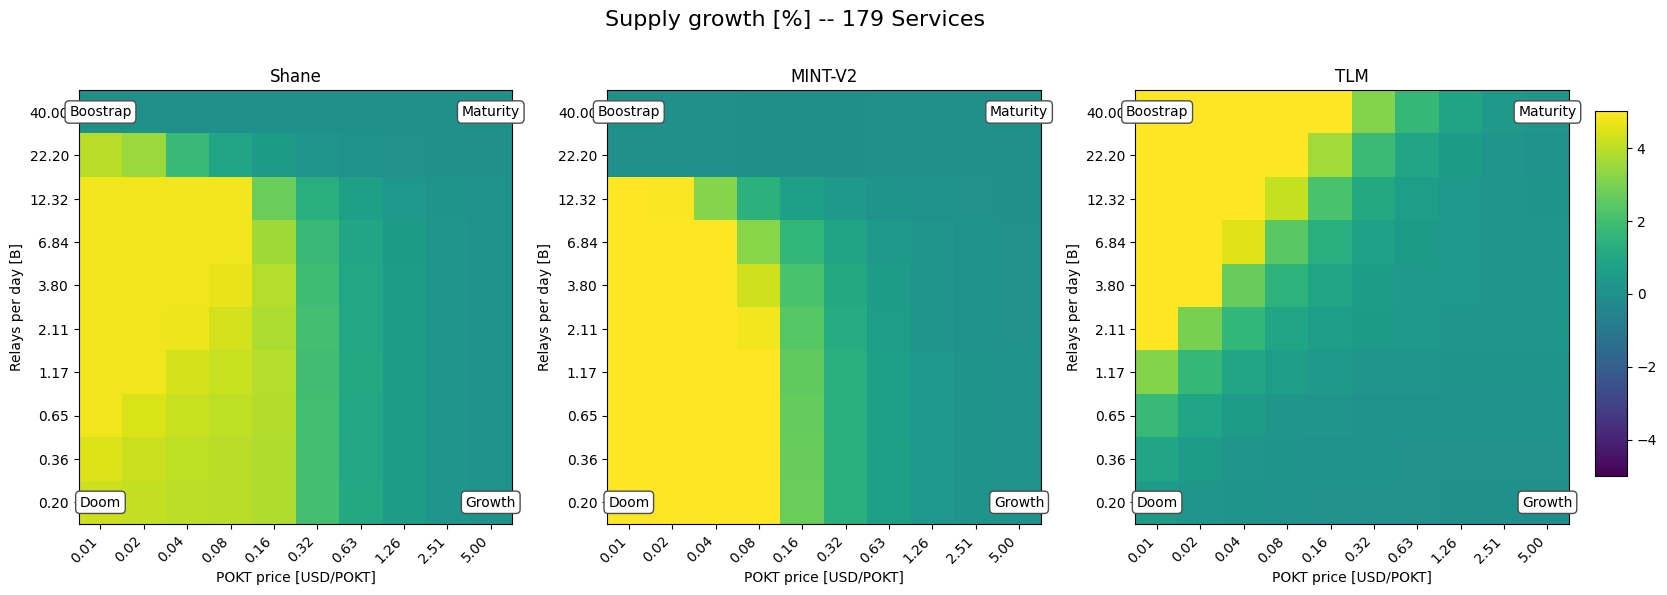

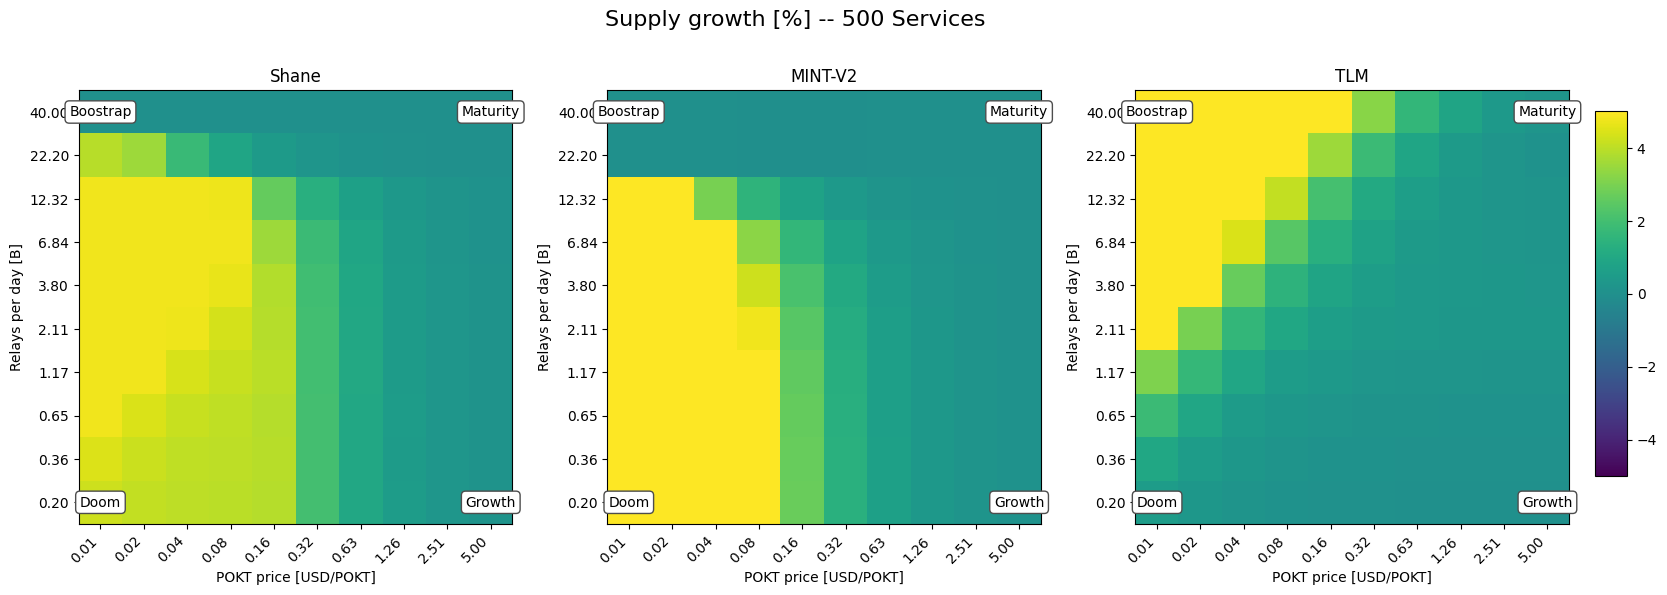

In [17]:

for num_services_idx in num_services_show:
        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Supply growth [%%] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list), idx+1)
                total_mint_grid = agg_results[model]['Total Mint'][feat][:,:,num_services_idx]
                total_burn_grid = agg_results[model]['Total Burn'][feat][:,:,num_services_idx]

                supply_growth = ((total_mint_grid-total_burn_grid)*365/network_macro['total_supply'])*100.

                data_show = supply_growth[::-1]
                im = plt.imshow(data_show,
                        #    norm=LogNorm(),
                        cmap='viridis',
                        interpolation='nearest')
                im.set_clim(color_map_supply_grow_limits)

                plt.title(model)

                plt.ylabel('Relays per day [B]')
                plt.xlabel('POKT price [USD/POKT]')



                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]

                plt.xticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)

                if len(models_list) == idx+1:
                        cax = fig.add_axes([ax.get_position().x1+0.1,ax.get_position().y0,0.02,ax.get_position().height])
                        plt.colorbar(im, cax=cax)  # Show the color scale

                ax.text(0, 0, "Boostrap",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(0, data_show.shape[1]-1, "Doom",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, data_show.shape[1]-1, "Growth",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, 0, "Maturity",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))


        plt.tight_layout()
        plt.show()

Same but 3D, just because...

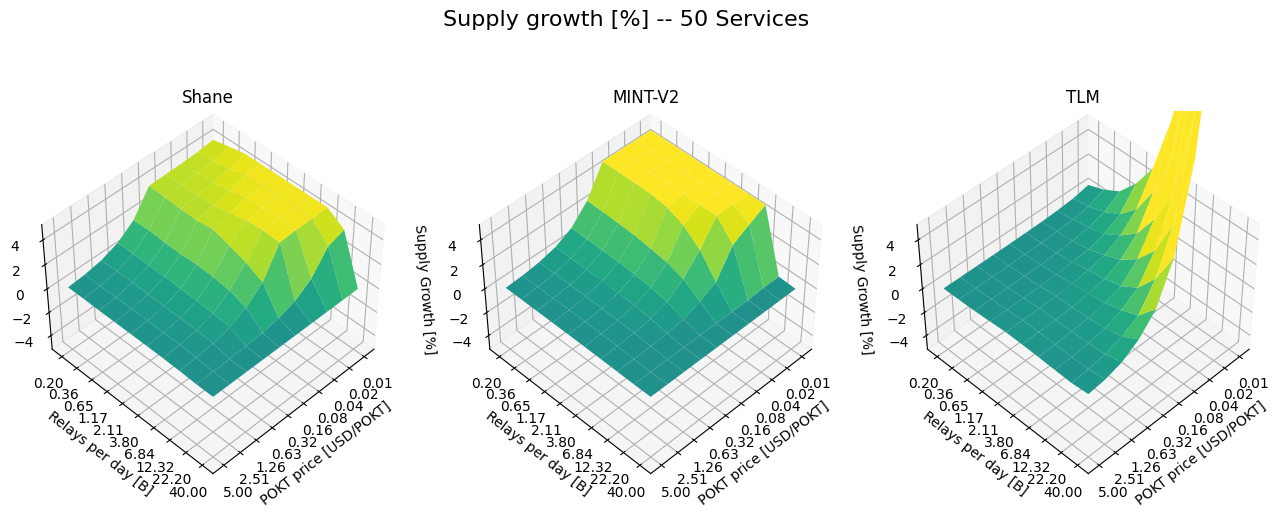

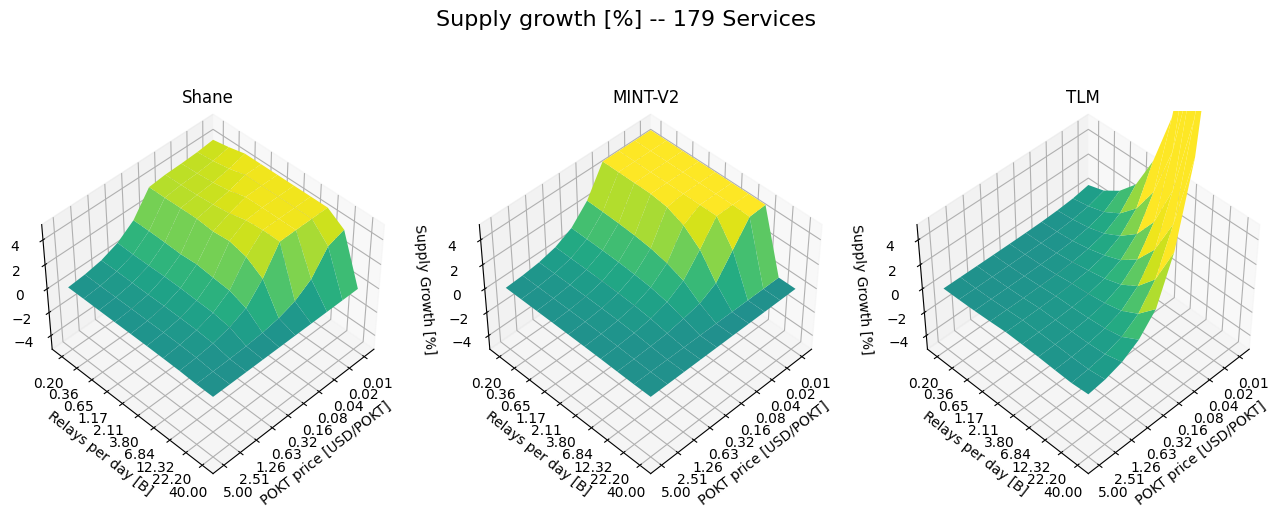

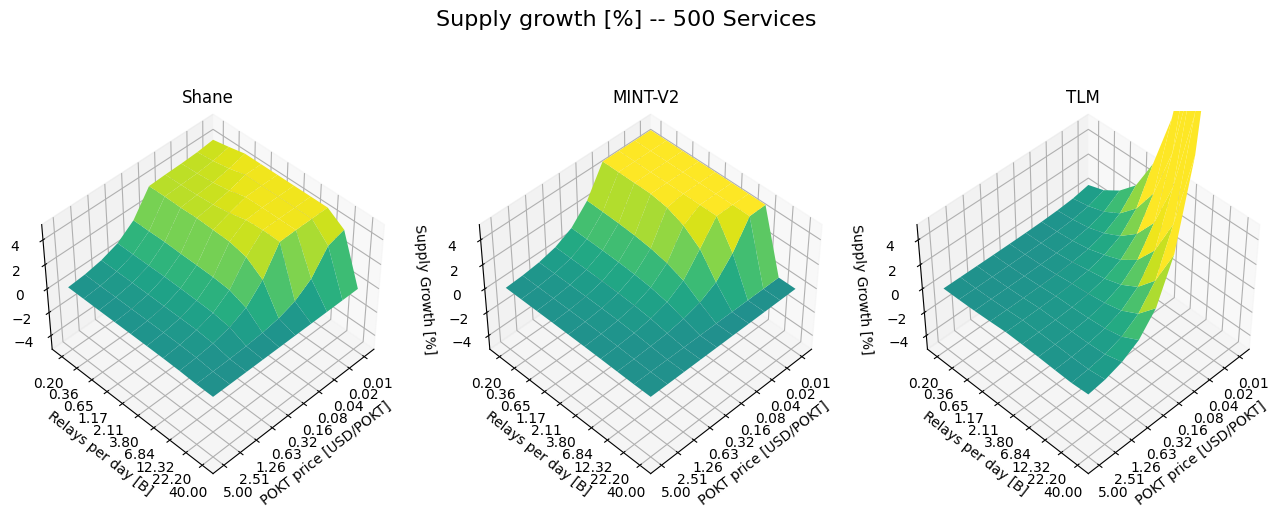

In [18]:
for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Supply growth [%%] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1, projection='3d')

                total_mint_grid = agg_results[model]['Total Mint'][feat][:,:,num_services_idx]
                total_burn_grid = agg_results[model]['Total Burn'][feat][:,:,num_services_idx]

                supply_growth = ((total_mint_grid-total_burn_grid)*365/network_macro['total_supply'])*100.


                # Create x and y coordinates (if needed)
                X, Y = np.meshgrid(np.arange(supply_growth.shape[0]), np.arange(supply_growth.shape[1]))

                # Plot the surface
                surf = ax.plot_surface(X, Y, supply_growth, cmap='viridis')  # Adjust colormap as desired
                surf.set_clim(color_map_supply_grow_limits)

                azimuth_angle = 45 #45  # Adjust for desired view (0 to 360 degrees)
                elevation_angle = 45  # Adjust for desired view (0 to 90 degrees)

                ax.view_init(elev=elevation_angle, azim=azimuth_angle)

                # Set labels and title
                ax.set_ylabel('Relays per day [B]')
                ax.set_xlabel('POKT price [USD/POKT]')
                ax.set_zlabel('Supply Growth [%]')

                ax.set_zlim(color_map_supply_grow_limits)

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]

                plt.title(model)

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)


        plt.show()

### Suplier Income in USD

This is the total amount of USD paid per day to Supliers (it is obtained from converting the POKT into USD, not that we can print USD)

/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_86002/3946870877.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


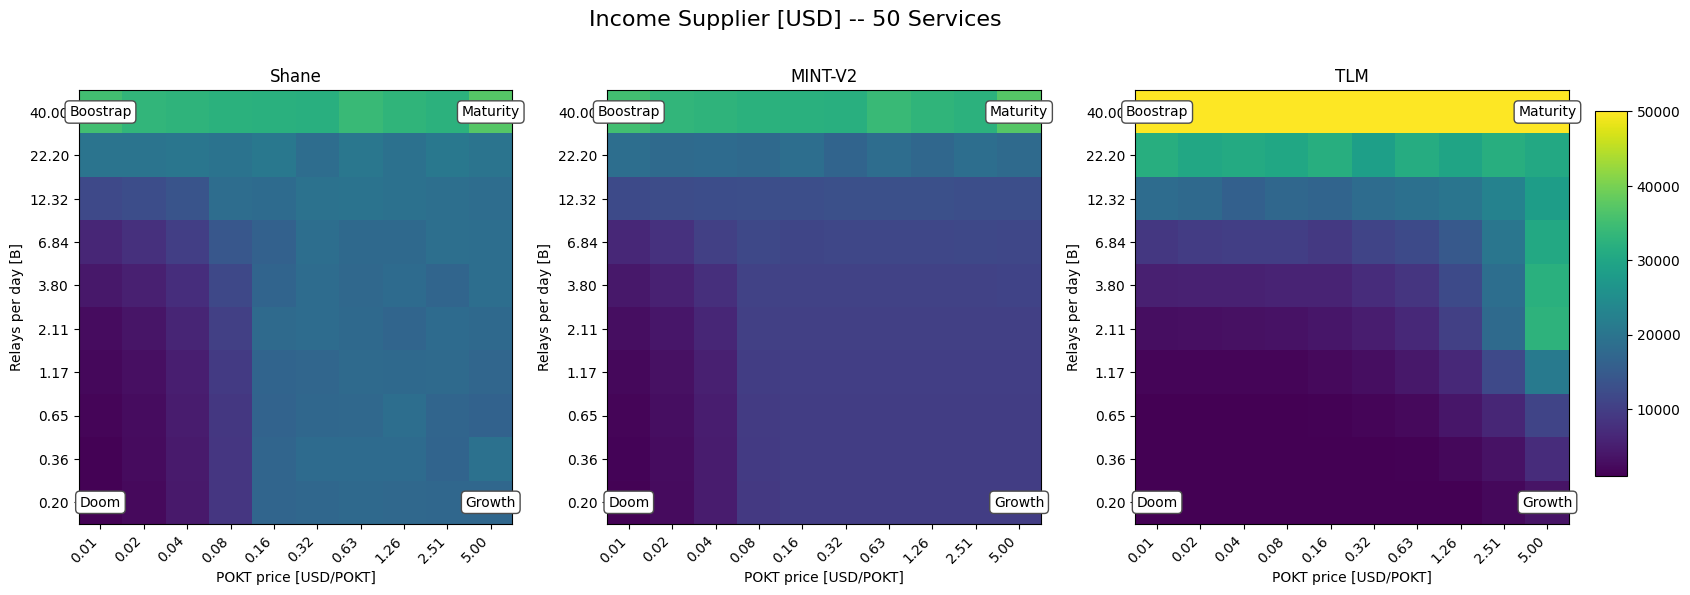

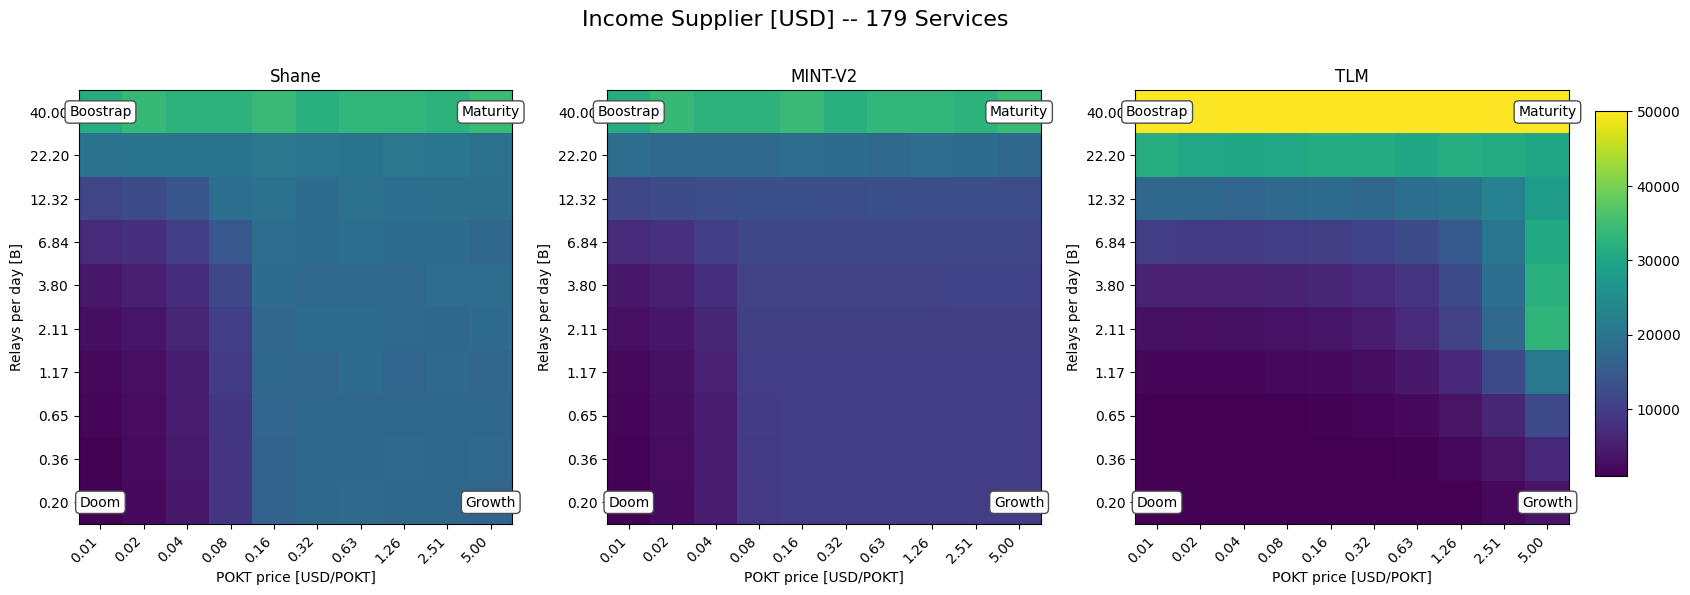

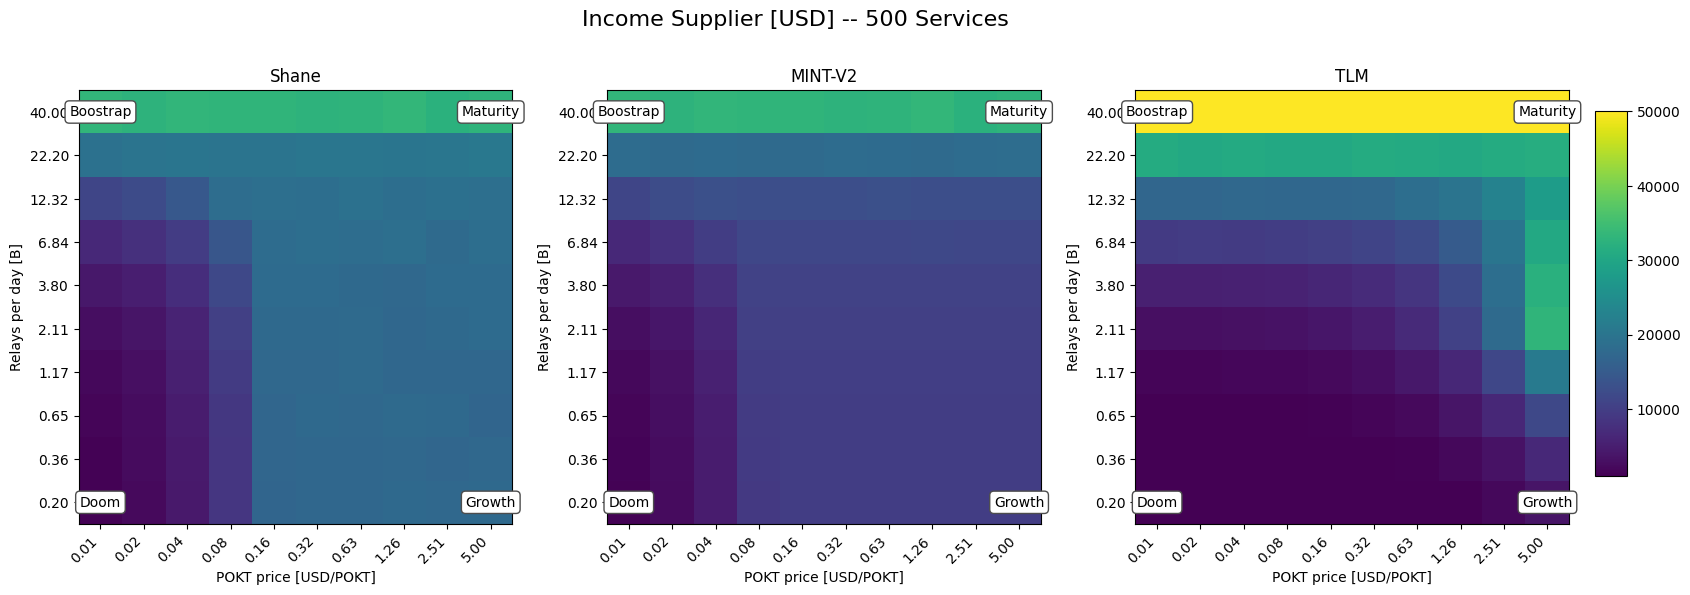

In [19]:
for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Income Supplier [USD] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1)

                income_suplier_grid = agg_results[model]['Income Supplier'][feat][:,:,num_services_idx]

                income_suplier_grid_usd = deepcopy(income_suplier_grid)
                for i_r, relays_now in enumerate(relays_sweep):
                        for i_p, price_now in enumerate(price_sweep):
                                income_suplier_grid_usd[i_r, i_p] *= price_now
                data_show = income_suplier_grid_usd[::-1]
                im = plt.imshow(data_show,
                        #    norm=LogNorm(),
                        cmap='viridis',
                        interpolation='nearest')
                im.set_clim(color_map_income_limits)

                plt.title(model)
                plt.ylabel('Relays per day [B]')
                plt.xlabel('POKT price [USD/POKT]')

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]
                plt.xticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)


                if len(models_list) == idx+1:
                        cax = fig.add_axes([ax.get_position().x1+0.1,ax.get_position().y0,0.02,ax.get_position().height])
                        plt.colorbar(im, cax=cax)  # Show the color scale

                ax.text(0, 0, "Boostrap",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(0, data_show.shape[1]-1, "Doom",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, data_show.shape[1]-1, "Growth",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, 0, "Maturity",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))


        plt.tight_layout()
        plt.show()

3D once more!

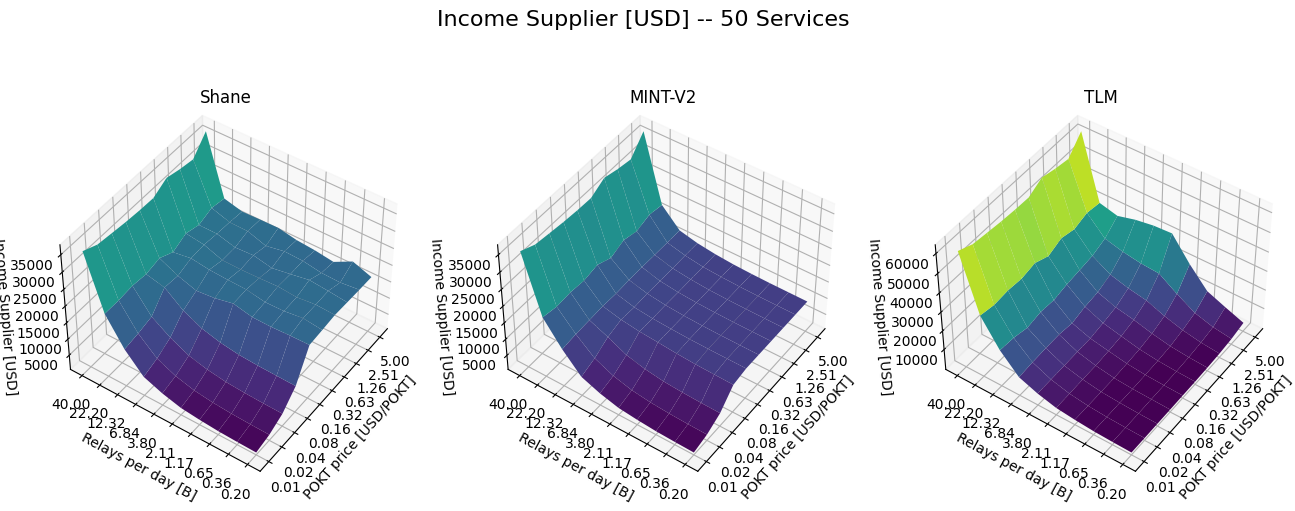

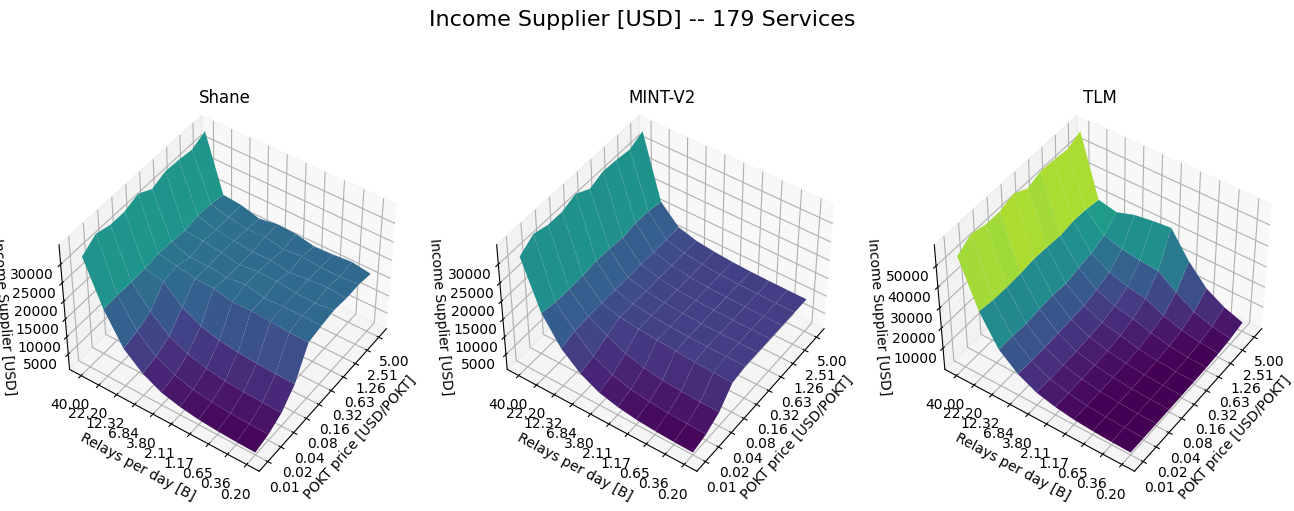

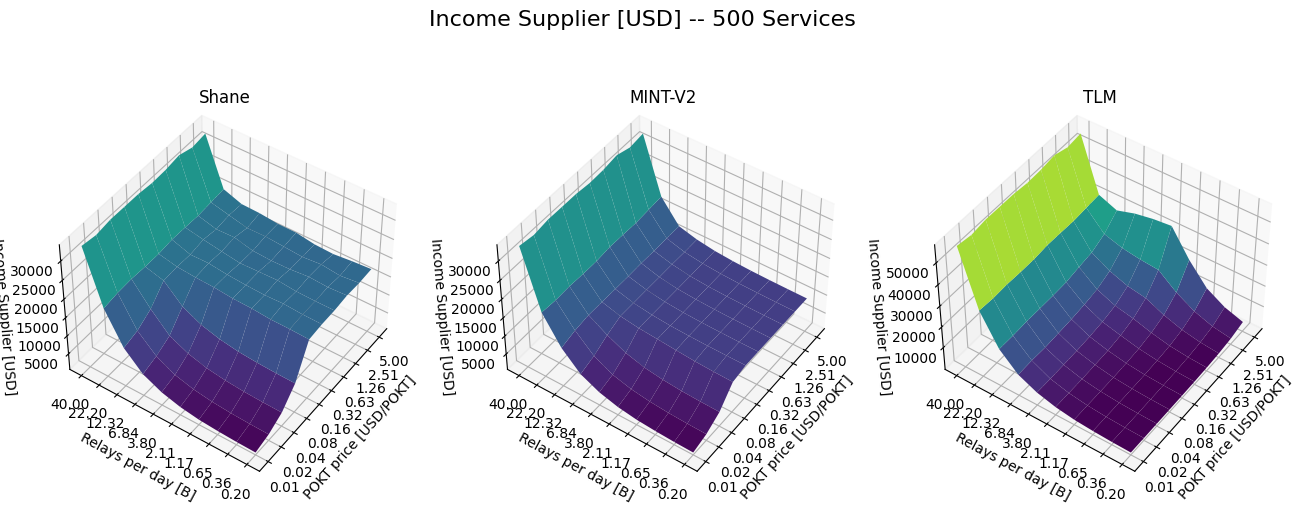

In [20]:
for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Income Supplier [USD] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1, projection='3d')

                income_suplier_grid = agg_results[model]['Income Supplier'][feat][:,:,num_services_idx]

                income_suplier_grid_usd = deepcopy(income_suplier_grid)
                for i_r, relays_now in enumerate(relays_sweep):
                        for i_p, price_now in enumerate(price_sweep):
                                income_suplier_grid_usd[i_r, i_p] *= price_now

                # Create x and y coordinates (if needed)
                X, Y = np.meshgrid(np.arange(income_suplier_grid_usd.shape[0]), np.arange(income_suplier_grid_usd.shape[1]))

                # Plot the surface
                surf = ax.plot_surface(X, Y, income_suplier_grid_usd, cmap='viridis')  # Adjust colormap as desired
                surf.set_clim(color_map_income_limits)


                # ax.contour(X, Y, income_suplier_grid_usd, levels=[0], cmap='gray', linewidths=1)  # adjust linewidths

                azimuth_angle = 215 #45  # Adjust for desired view (0 to 360 degrees)
                elevation_angle = 45  # Adjust for desired view (0 to 90 degrees)

                ax.view_init(elev=elevation_angle, azim=azimuth_angle)

                # Set labels and title
                ax.set_ylabel('Relays per day [B]')
                ax.set_xlabel('POKT price [USD/POKT]')
                ax.set_zlabel('Income Supplier [USD]')

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]

                # plt.xticks(rotation=45, ha='left')
                # plt.yticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)




                plt.title(model)

        plt.show()

### Node APY (Network Averaged)

This is the APY calculated from total network minting and nodes. Its a very diluted number because it does not take into account per-service variations from compute costs.

/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_86002/774745640.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


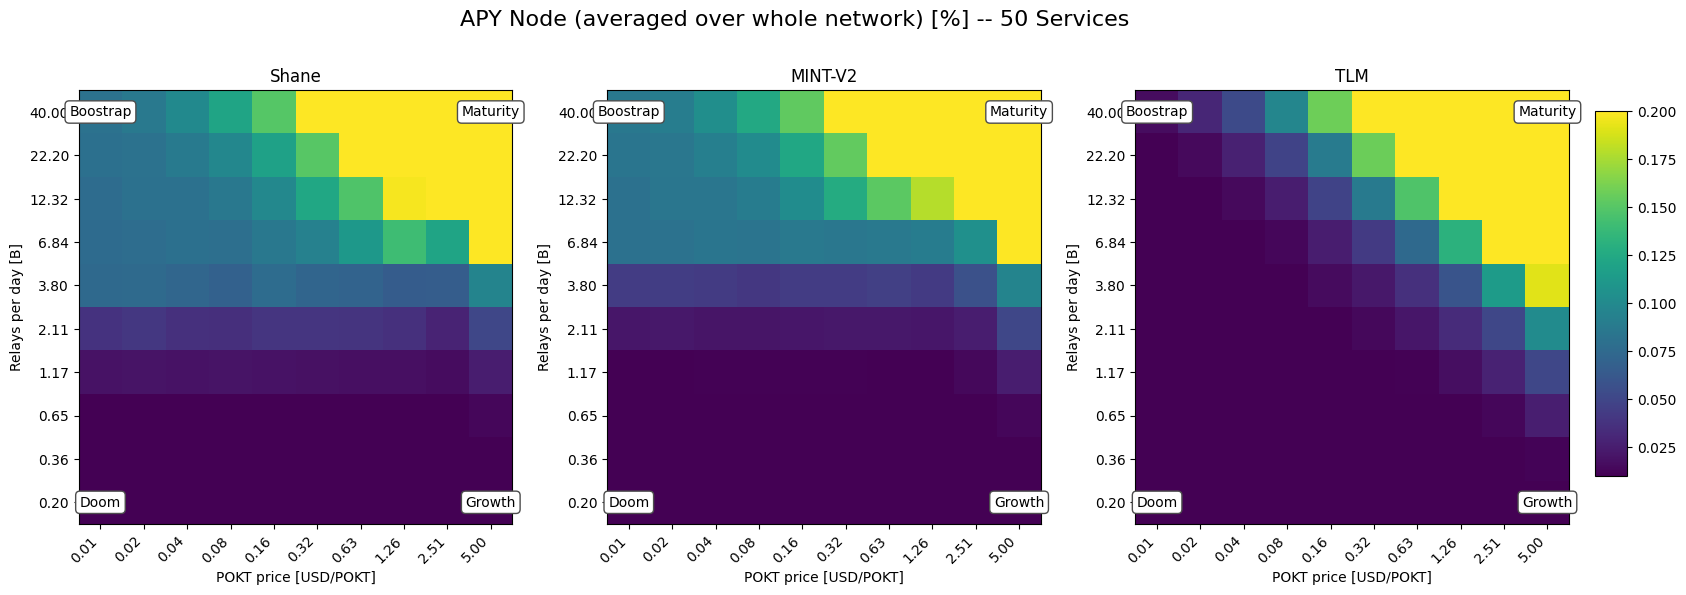

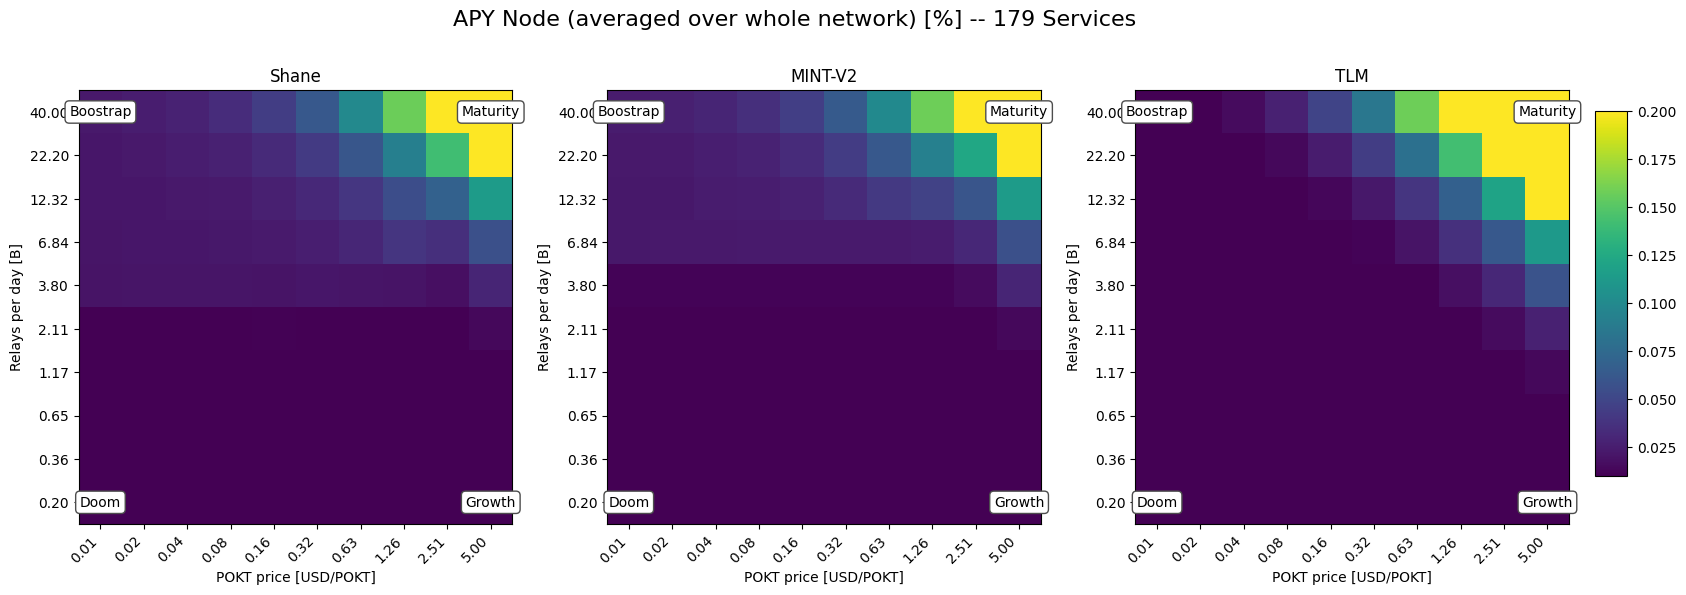

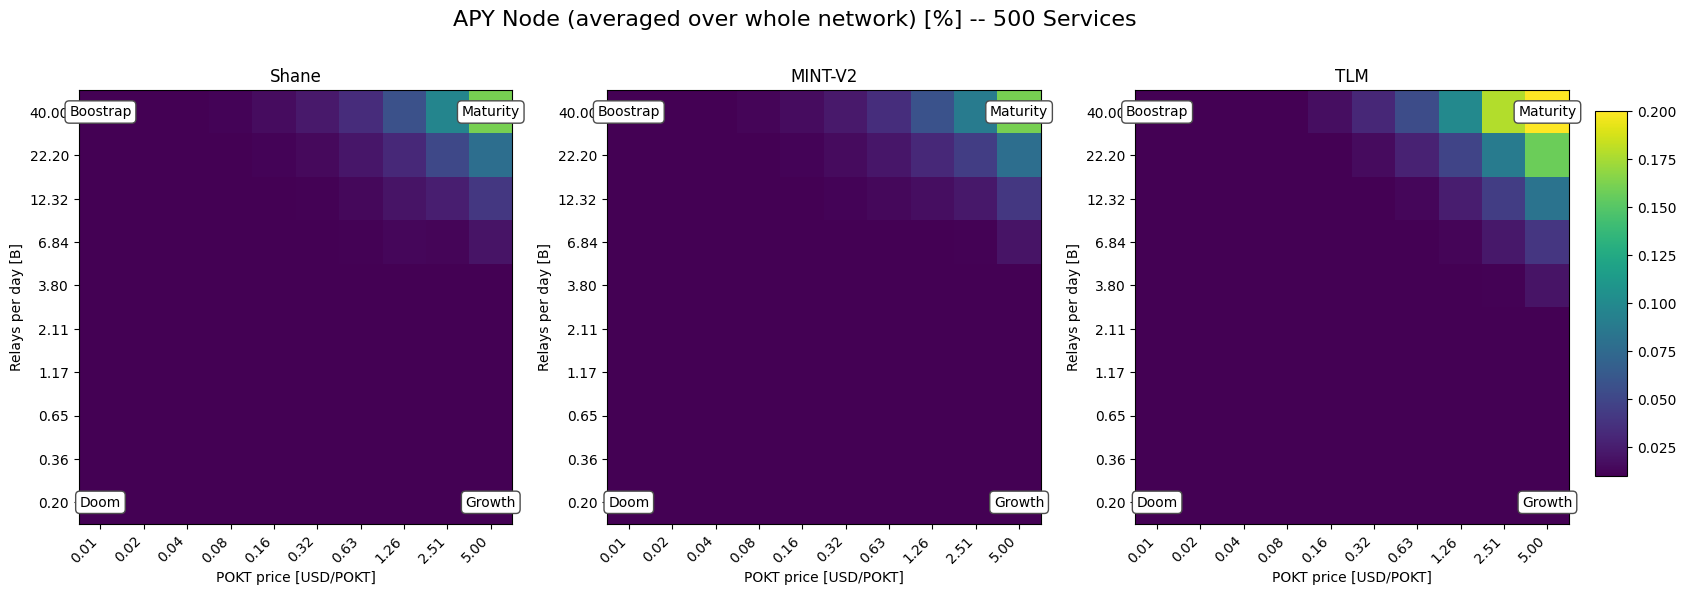

In [21]:
for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('APY Node (averaged over whole network) [%%] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1)

                node_APR_grid = agg_results[model]['Node APR'][feat][:,:,num_services_idx]

                data_show = node_APR_grid.T
                im = plt.imshow(data_show,
                        #    norm=LogNorm(),
                        cmap='viridis',
                        interpolation='nearest')
                im.set_clim(node_apy_colorbar_limits)

                plt.title(model)
                plt.ylabel('Relays per day [B]')
                plt.xlabel('POKT price [USD/POKT]')

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]
                plt.xticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)

                ax.text(0, 0, "Boostrap",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(0, data_show.shape[1]-1, "Doom",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, data_show.shape[1]-1, "Growth",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, 0, "Maturity",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))



                if len(models_list) == idx+1:
                        cax = fig.add_axes([ax.get_position().x1+0.1,ax.get_position().y0,0.02,ax.get_position().height])
                        plt.colorbar(im, cax=cax)  # Show the color scale

        plt.tight_layout()
        plt.show()

# Node Mean Income

This is the actual mean income in POKT, not averaged though the whole network, but grouped by service (as the node runner actually sees it in a 1 chain 1 node network).

/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_86002/1461045426.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


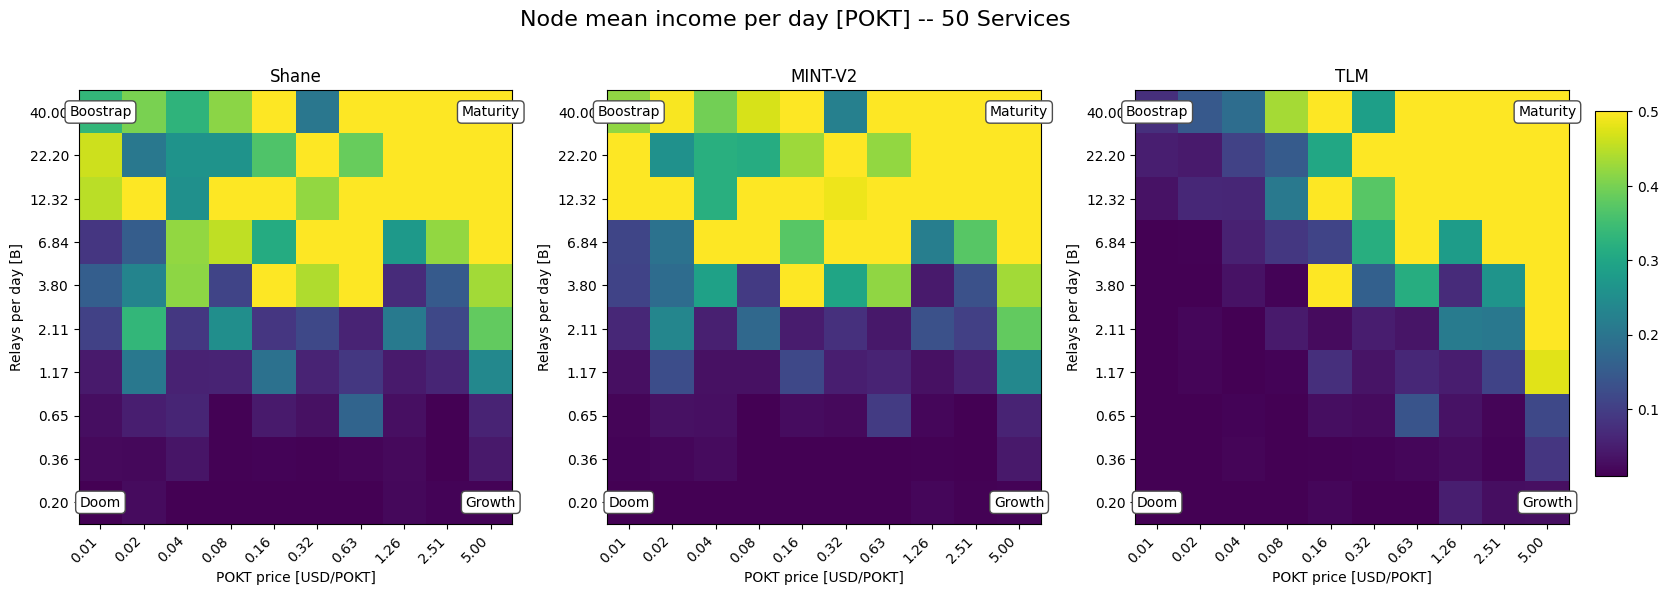

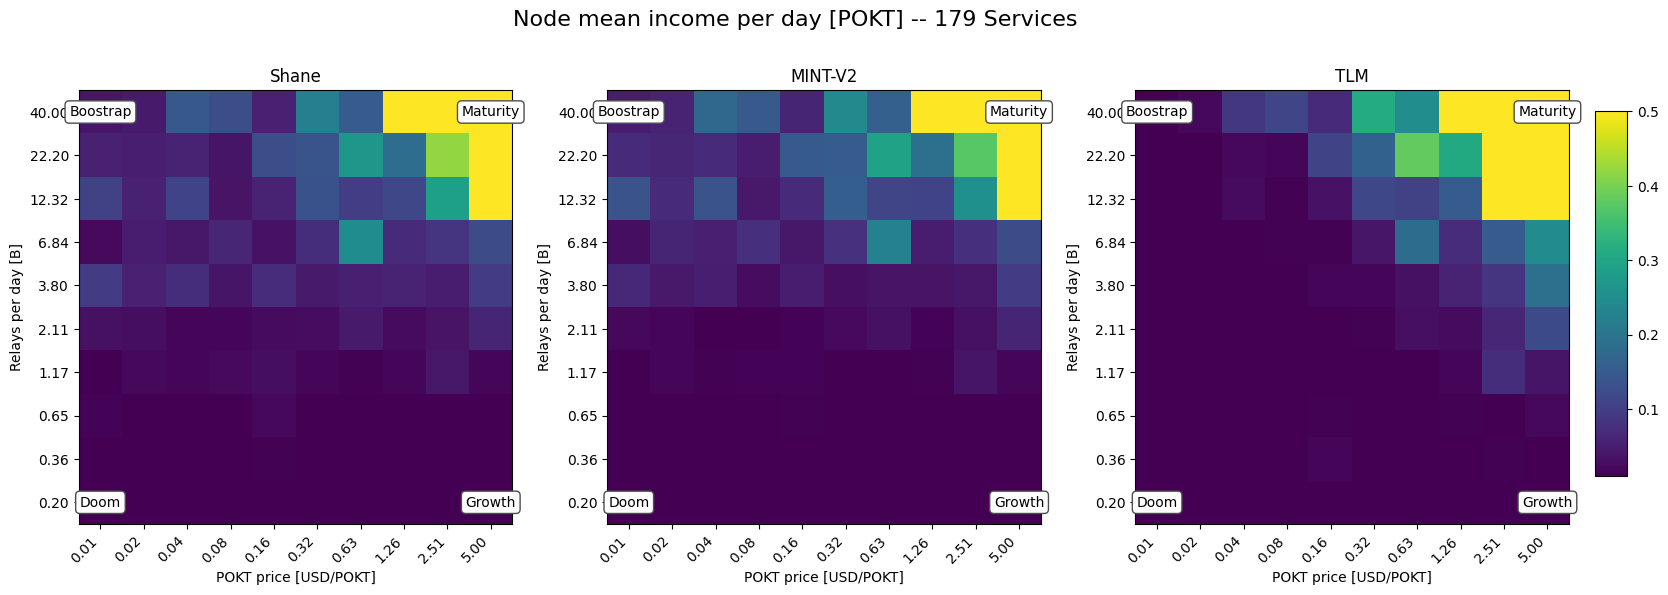

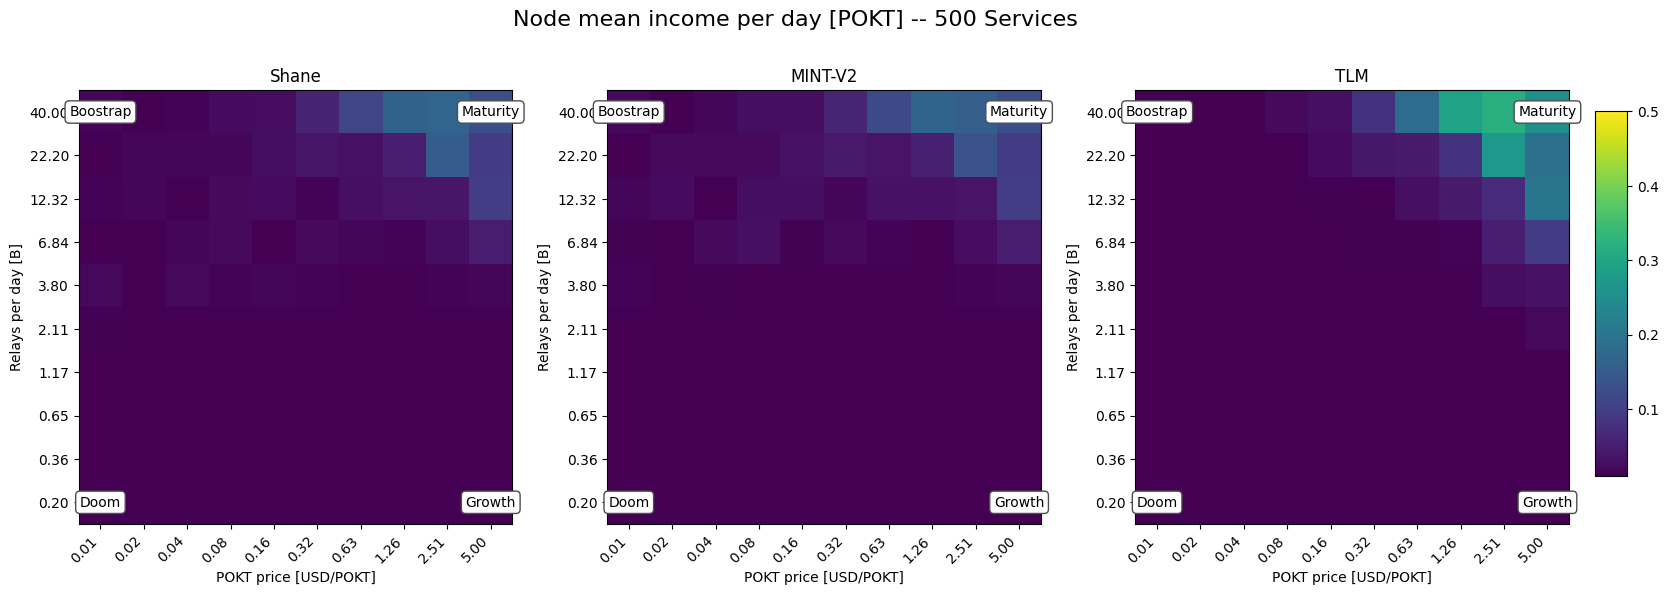

In [22]:

for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Node mean income per day [POKT] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1)

                node_me_grid = agg_results[model]['Income Node per Service']['std'][:,:,num_services_idx]

                data_show = node_me_grid.T
                im = plt.imshow(data_show,
                        #    norm=LogNorm(),
                        cmap='viridis',
                        interpolation='nearest')
                im.set_clim(node_mean_income_colorbar_limits)

                plt.title(model)
                plt.ylabel('Relays per day [B]')
                plt.xlabel('POKT price [USD/POKT]')

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]
                plt.xticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)

                ax.text(0, 0, "Boostrap",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(0, data_show.shape[1]-1, "Doom",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, data_show.shape[1]-1, "Growth",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, 0, "Maturity",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))



                if len(models_list) == idx+1:
                        cax = fig.add_axes([ax.get_position().x1+0.1,ax.get_position().y0,0.02,ax.get_position().height])
                        plt.colorbar(im, cax=cax)  # Show the color scale

        plt.tight_layout()
        plt.show()

Now we calculate the error of that mean, which tell us how much the node income varies from service to service.
Higher values here are bad, they mean more error, an spreader distribution.

/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_86002/4113478625.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


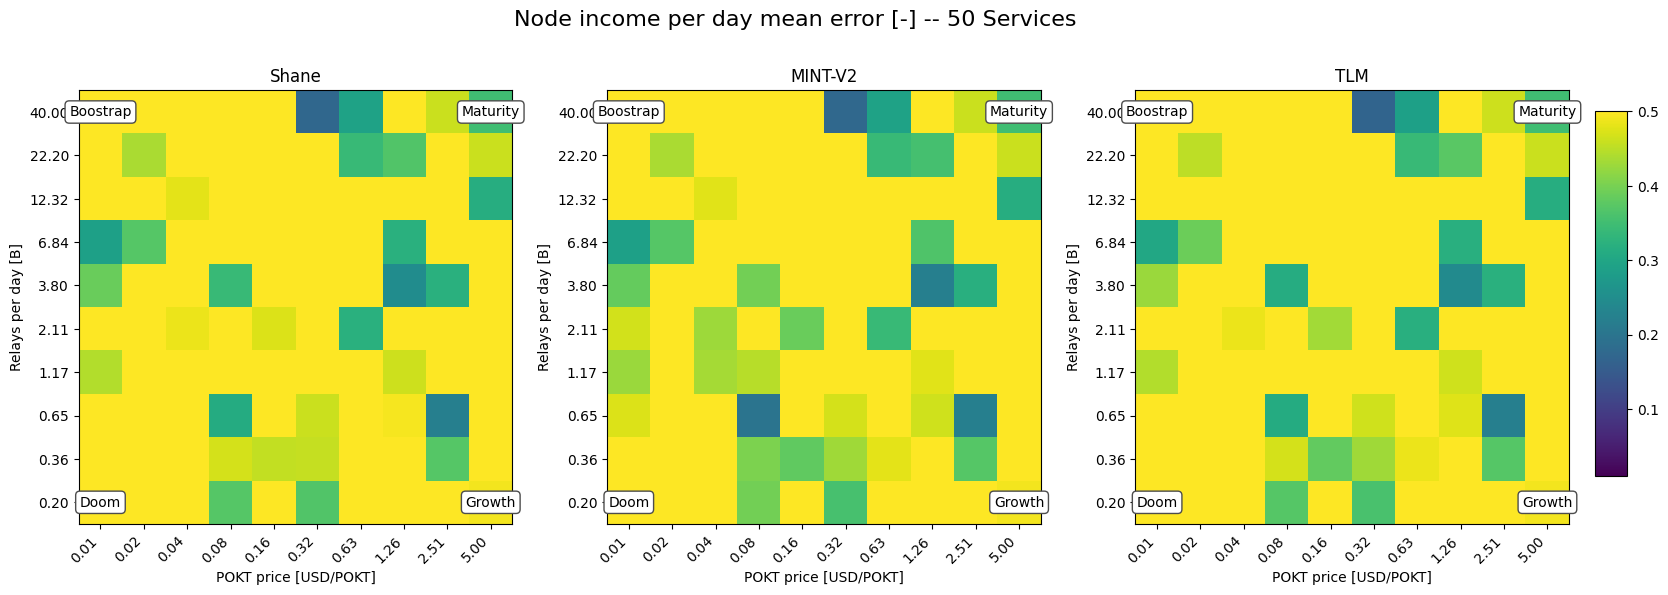

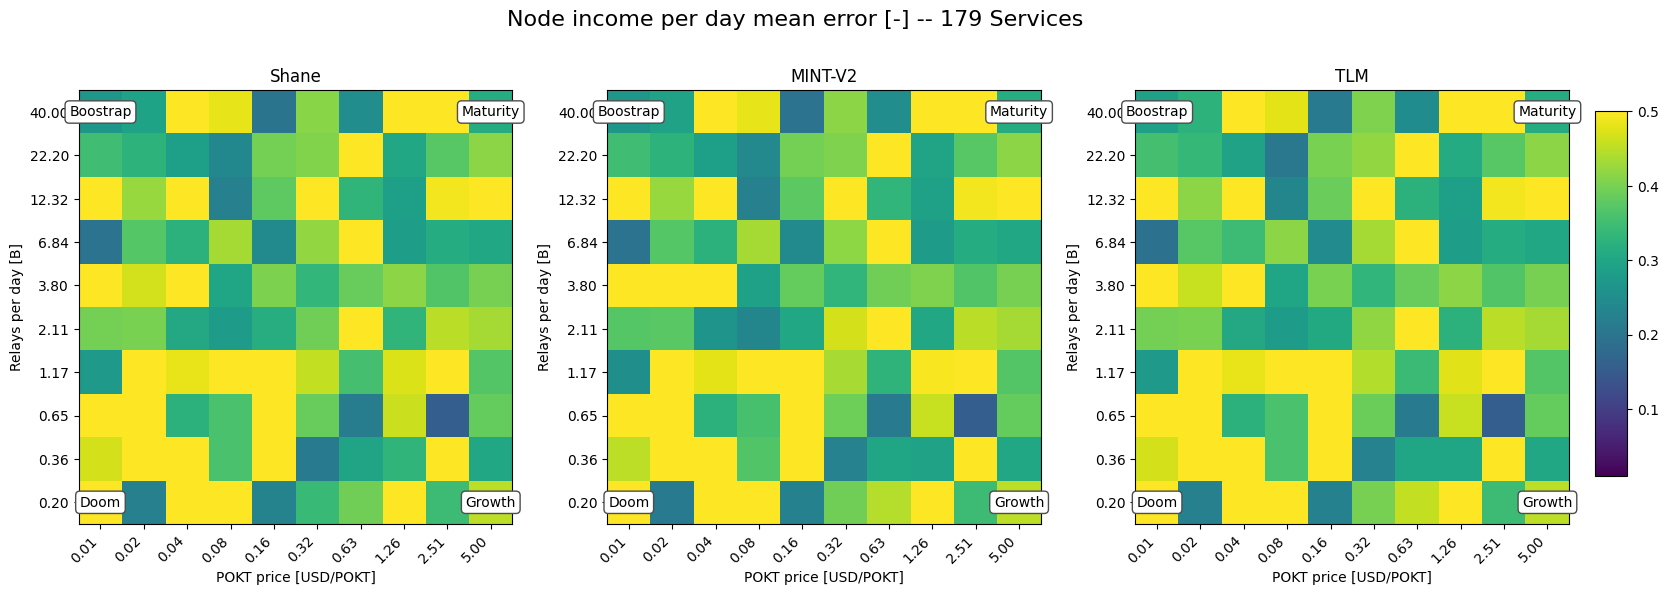

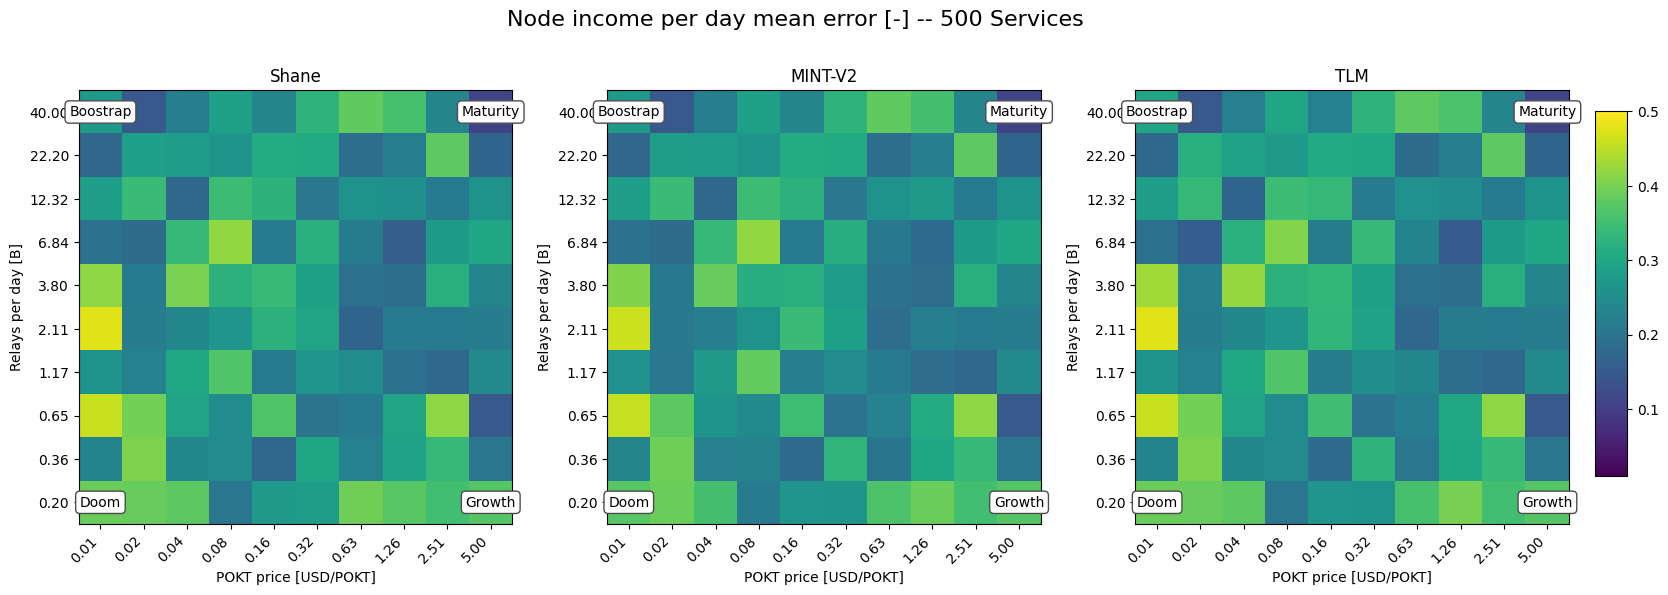

In [23]:

for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Node income per day mean error [-] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1)

                node_me_grid = agg_results[model]['Income Node per Service']['std'][:,:,num_services_idx] /\
                                agg_results[model]['Income Node per Service']['mean'][:,:,num_services_idx]

                data_show = node_me_grid.T
                im = plt.imshow(data_show,
                        #    norm=LogNorm(),
                        cmap='viridis',
                        interpolation='nearest')
                im.set_clim(node_mean_income_colorbar_limits)

                plt.title(model)
                plt.ylabel('Relays per day [B]')
                plt.xlabel('POKT price [USD/POKT]')

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]
                plt.xticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)

                ax.text(0, 0, "Boostrap",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(0, data_show.shape[1]-1, "Doom",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, data_show.shape[1]-1, "Growth",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, 0, "Maturity",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))


                if len(models_list) == idx+1:
                        cax = fig.add_axes([ax.get_position().x1+0.1,ax.get_position().y0,0.02,ax.get_position().height])
                        plt.colorbar(im, cax=cax)  # Show the color scale

        plt.tight_layout()
        plt.show()

### Over and Under Provisioned

Here we calculate how much a node that is under or over provisioned earns compared to the network average. So, this ratio reflects the increased gains for staking in under-provisioned chains and the reduced gains for staking in an over-provisioned one.


/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_86002/1596636531.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


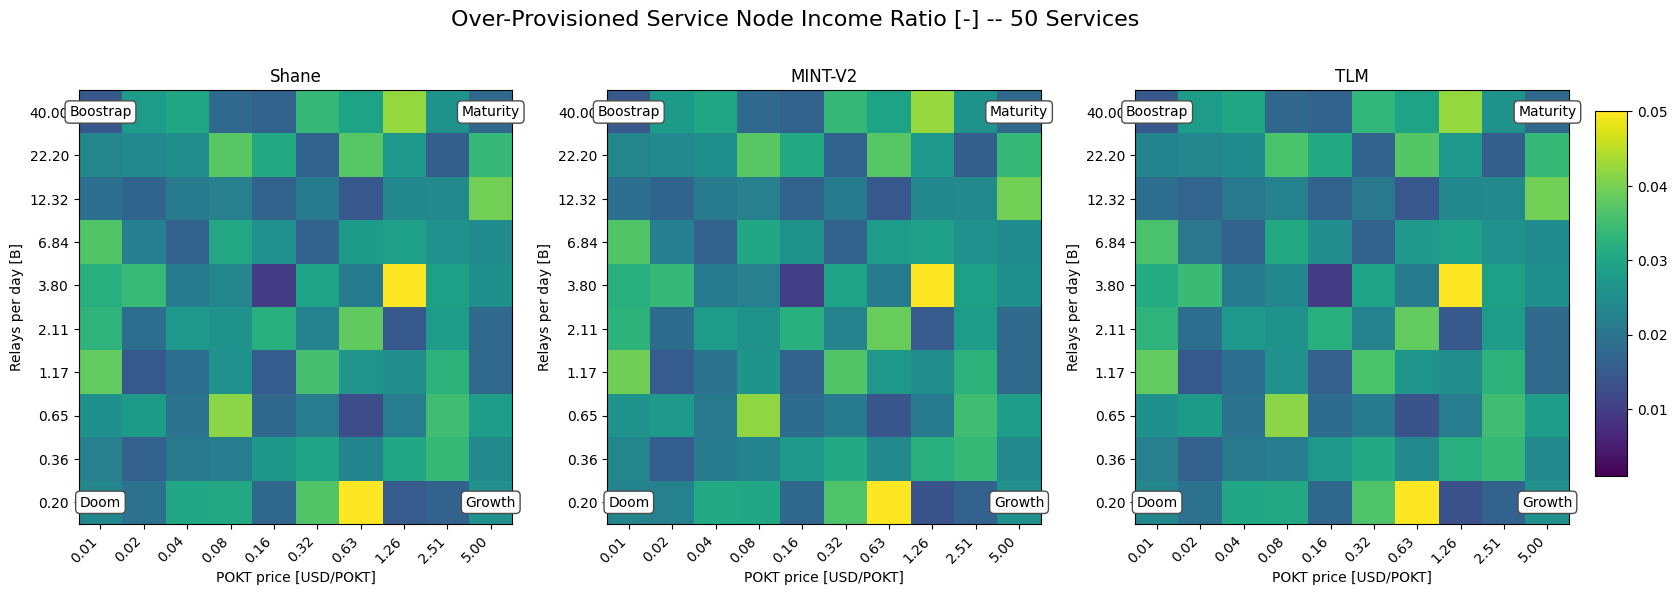

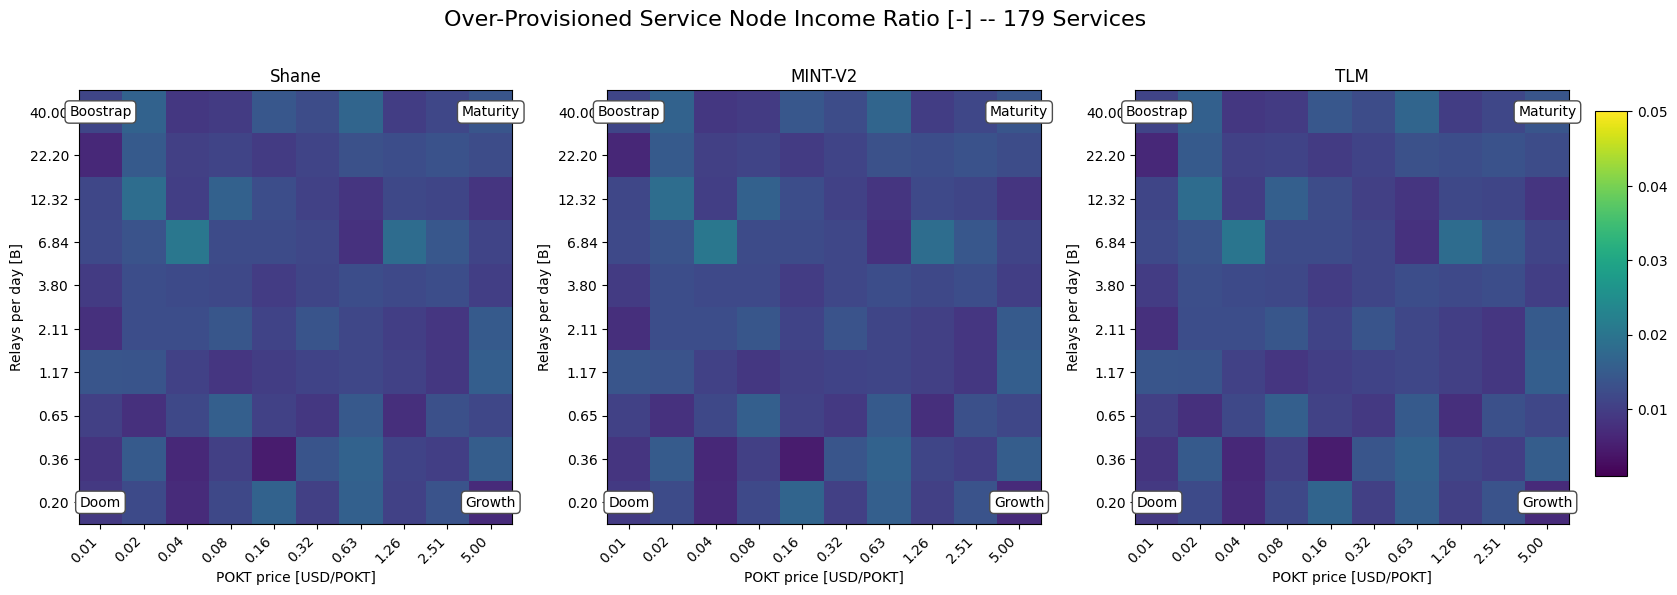

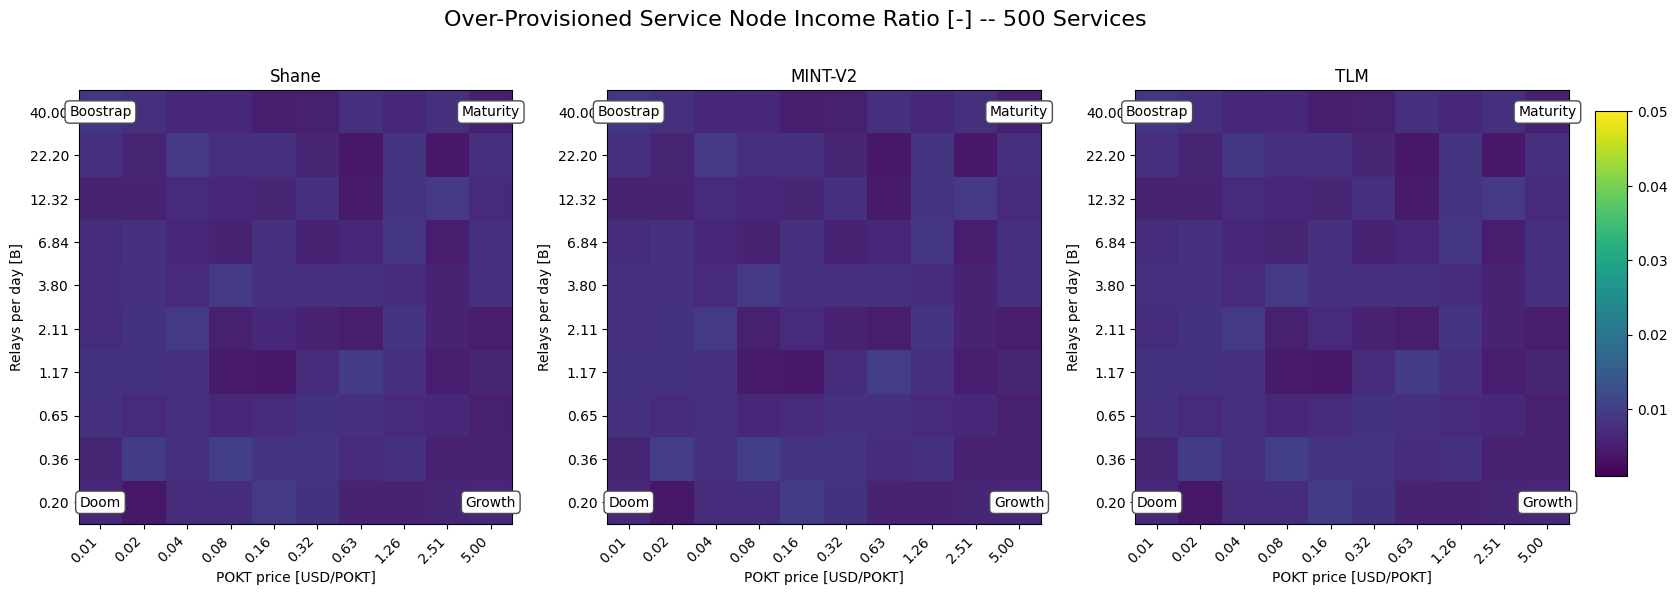

In [24]:

for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Over-Provisioned Service Node Income Ratio [-] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1)

                node_me_grid = agg_results[model]['Over-Provisioned Income Node per Service']['mean'][:,:,num_services_idx] /\
                                agg_results[model]['Income Node per Service']['mean'][:,:,num_services_idx]

                data_show = node_me_grid.T
                im = plt.imshow(data_show,
                        #    norm=LogNorm(),
                        cmap='viridis',
                        interpolation='nearest')
                im.set_clim(over_provision_colorbar_limits)

                plt.title(model)
                plt.ylabel('Relays per day [B]')
                plt.xlabel('POKT price [USD/POKT]')

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]
                plt.xticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)

                ax.text(0, 0, "Boostrap",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(0, data_show.shape[1]-1, "Doom",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, data_show.shape[1]-1, "Growth",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, 0, "Maturity",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))



                if len(models_list) == idx+1:
                        cax = fig.add_axes([ax.get_position().x1+0.1,ax.get_position().y0,0.02,ax.get_position().height])
                        plt.colorbar(im, cax=cax)  # Show the color scale

        plt.tight_layout()
        plt.show()

/var/folders/nv/mc18v4l15qz0rbn5wdzv0qlh0000gp/T/ipykernel_86002/720505895.py:55: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


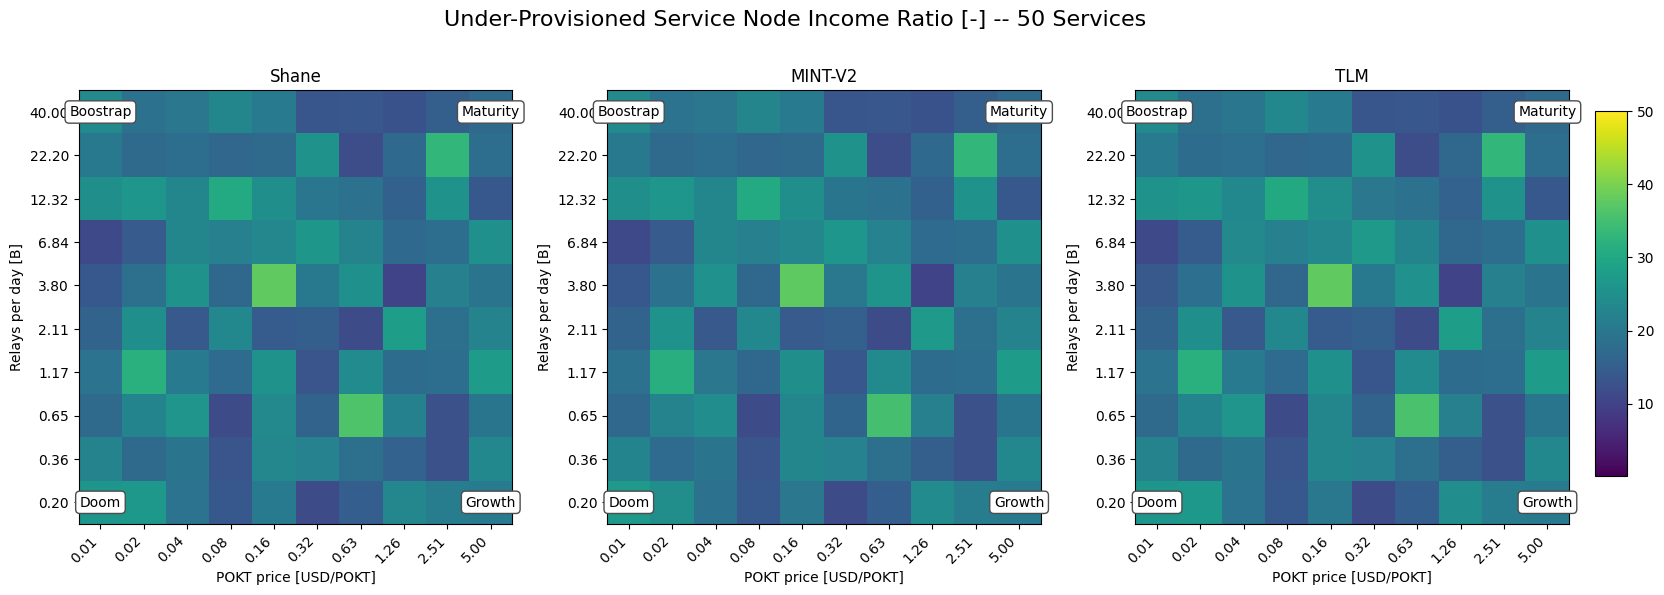

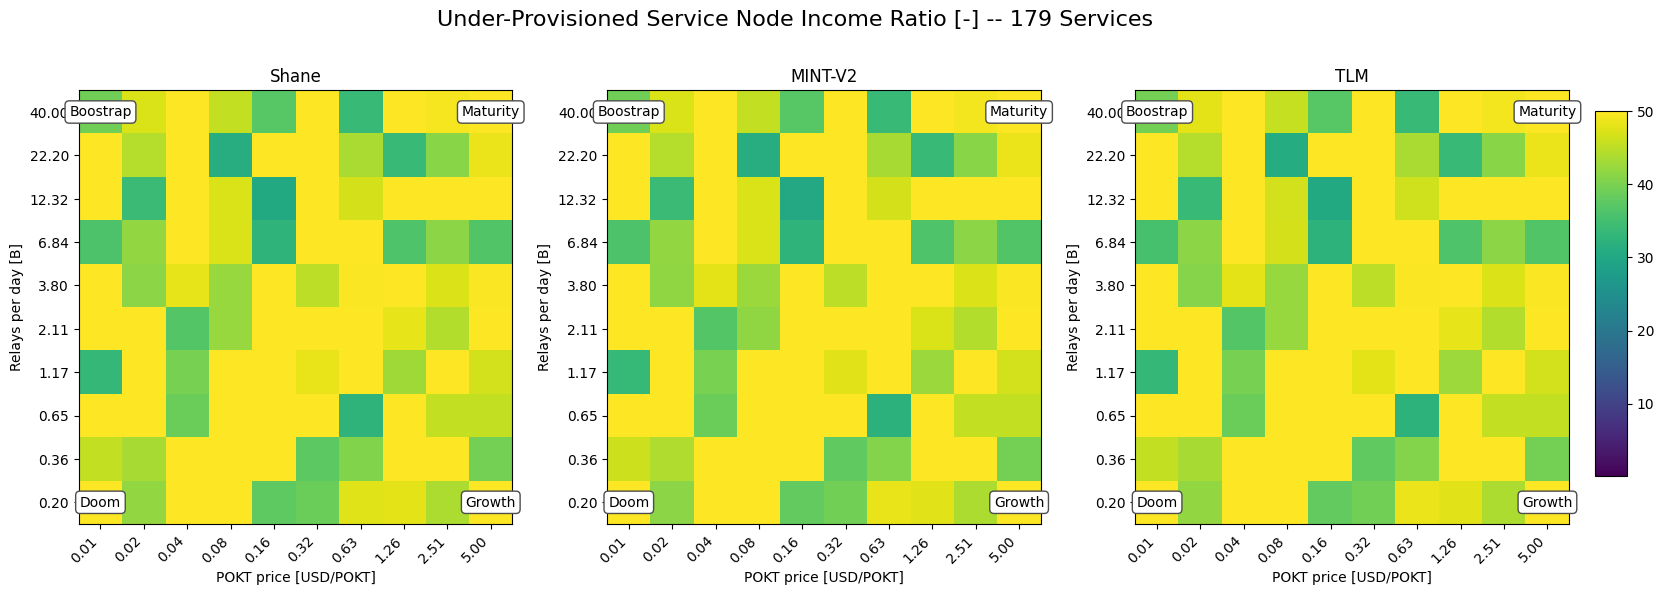

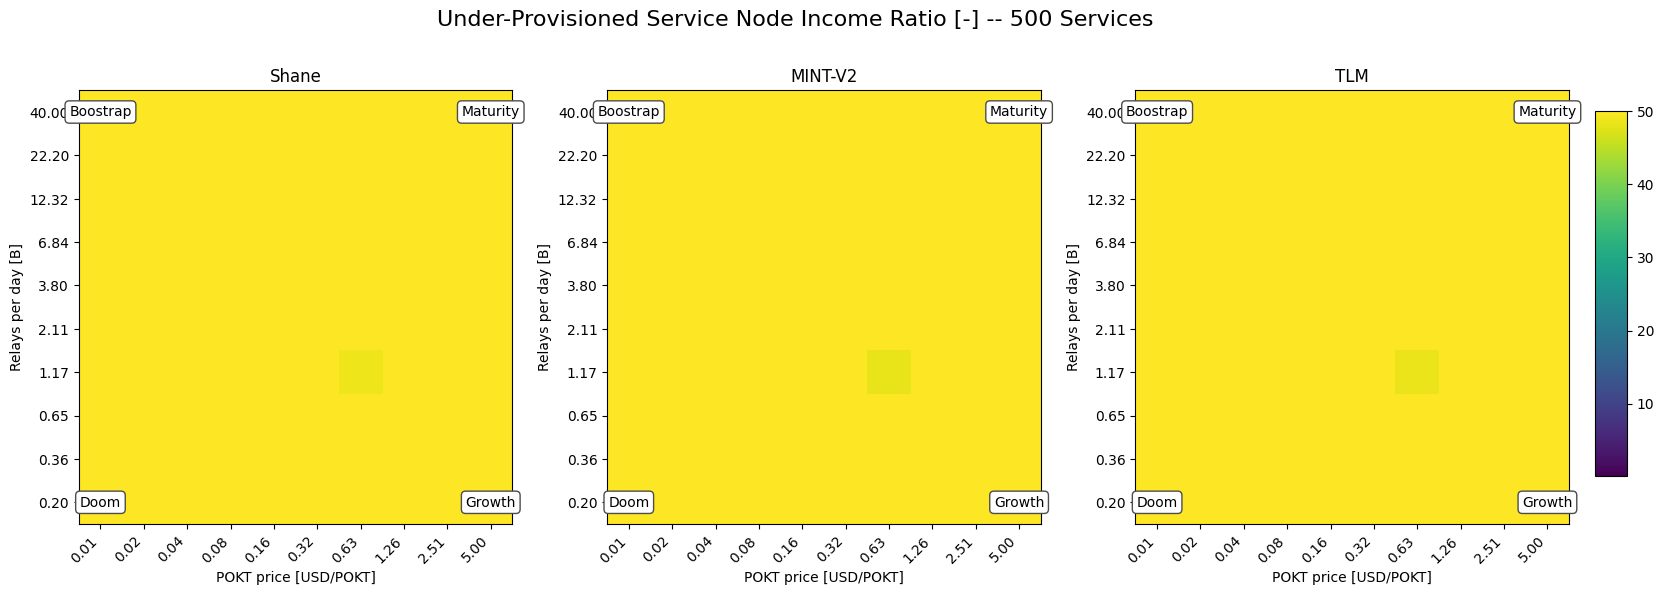

In [25]:

for num_services_idx in num_services_show:

        fig = plt.figure(figsize=(16, 8))
        fig.suptitle('Under-Provisioned Service Node Income Ratio [-] -- %d Services'%int(services_sweep[num_services_idx]), size=16, y=0.85)
        for idx, model in enumerate(models_list):
                ax =plt.subplot(1,len(models_list),idx+1)

                node_me_grid = agg_results[model]['Under-Provisioned Income Node per Service']['mean'][:,:,num_services_idx] /\
                                agg_results[model]['Income Node per Service']['mean'][:,:,num_services_idx]

                data_show = node_me_grid.T
                im = plt.imshow(data_show,
                        #    norm=LogNorm(),
                        cmap='viridis',
                        interpolation='nearest')
                im.set_clim(under_provision_colorbar_limits)

                plt.title(model)
                plt.ylabel('Relays per day [B]')
                plt.xlabel('POKT price [USD/POKT]')

                ticks = 10
                xticks = np.linspace(0, num_sweeps-1, ticks)
                yticks = np.linspace(0, num_sweeps-1, ticks)
                if USE_GEOM:
                        ytick_labels = ['%0.2f'%i for i in np.geomspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.geomspace(min_price_sweep, max_price_sweep, ticks)]
                else:
                        ytick_labels = ['%0.2f'%i for i in np.linspace(min_relays_sweep/1e9, max_relays_sweep/1e9, ticks)][::-1]
                        xtick_labels = ['%0.2f'%i for i in np.linspace(min_price_sweep, max_price_sweep, ticks)]
                plt.xticks(rotation=45, ha='right')

                plt.xticks(ticks=xticks, labels=xtick_labels)
                plt.yticks(ticks=yticks, labels=ytick_labels)

                ax.text(0, 0, "Boostrap",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(0, data_show.shape[1]-1, "Doom",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, data_show.shape[1]-1, "Growth",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))
                ax.text(data_show.shape[0]-1, 0, "Maturity",
                                ha='center', va='center', fontsize=10,
                                bbox=dict(boxstyle="round", facecolor='white', edgecolor='0.3'))



                if len(models_list) == idx+1:
                        cax = fig.add_axes([ax.get_position().x1+0.1,ax.get_position().y0,0.02,ax.get_position().height])
                        plt.colorbar(im, cax=cax)  # Show the color scale

        plt.tight_layout()
        plt.show()